# 1. Imports

In [1]:
using Revise

In [3]:
using NNHelferlein

https://github.com/andreasdominik/NNHelferlein.jl <br>
https://andreasdominik.github.io/NNHelferlein.jl/dev/

In [4]:
using Knet

In [5]:
using CSV
using DataFrames
using DelimitedFiles

In [6]:
using Plots
gr()

Plots.GRBackend()

In [7]:
using Statistics

In [8]:
using JLD2

# 2. Loading and preparing data - disease stage pN

In [9]:
trainingdata_pN = "trainingdata_balanced_pN.csv";
validationdata_pN = "validata_pN.csv";
testdata_pN = "testdata_pN.csv";

### 2.1 Geneexpression data + labels

In [10]:
trn_pN = dataframe_read(trainingdata_pN);
val_pN = dataframe_read(validationdata_pN);
tst_pN = dataframe_read(testdata_pN);

Reading data from CSV: trainingdata_balanced_pN.csv
Reading data from CSV: validata_pN.csv
Reading data from CSV: testdata_pN.csv


### 2.2 Minibatches

In [11]:
trn_pN_mb_frame = dataframe_minibatches(trn_pN, size=16, ignore=[1], teaching="DiseaseStage", partial=true, shuffle=true)

making minibatches from DataFrame:
... number of records used:  655
... teaching input y is:     DiseaseStage
... number of columns used:  22215
... data columns:            [1007_s_at, 1053_at ... 91920_at, 91952_at]
... number of classes:       3


41-element Knet.Train20.Data{Tuple{CuArray{Float32}, Array{UInt8}}}

In [12]:
val_pN_mb_frame = dataframe_minibatches(val_pN, size=16, ignore=[1], teaching="DiseaseStage", partial=true, shuffle=true)

making minibatches from DataFrame:
... number of records used:  164
... teaching input y is:     DiseaseStage
... number of columns used:  22215
... data columns:            [1007_s_at, 1053_at ... 91920_at, 91952_at]
... number of classes:       3


11-element Knet.Train20.Data{Tuple{CuArray{Float32}, Array{UInt8}}}

In [13]:
tst_pN_mb_frame = dataframe_minibatches(tst_pN, size=1, ignore=[1,2], teaching="DiseaseStage", partial=true, shuffle=true)

making minibatches from DataFrame:
... number of records used:  44
... teaching input y is:     DiseaseStage
... number of columns used:  22215
... data columns:            [1007_s_at, 1053_at ... 91920_at, 91952_at]
... number of classes:       3


44-element Knet.Train20.Data{Tuple{CuArray{Float32}, Array{UInt8}}}

# 5. Transform the data to minibtachtes with two times the same input

In [14]:
x_pN = Array{Float32}(trn_pN[:,3:end])';
trn_pN_mb = minibatch(x_pN,x_pN, 16, shuffle=false,partial=true);

In [15]:
x_pN = Array{Float32}(val_pN[:,3:end])';
val_pN_mb = minibatch(x_pN,x_pN, 16, shuffle=false,partial=true);

In [16]:
x_pN = Array{Float32}(tst_pN[:,4:end])';
tst_pN_mb = minibatch(x_pN,x_pN, 1, shuffle=false,partial=true);

# MLPAutoEncoder (mlpae)

struct for the autoencoder

In [17]:
struct AutoEncoder <: DNN
    layers
    AutoEncoder(e,d) = new([e,d])
end

function (ae::AutoEncoder)(x)
    # encode - decoder
    x = ae.layers[1](x)
    x = ae.layers[2](x)
    return x
end

# square loss:
(ae::AutoEncoder)(x, y) = sum(abs2, ae(x) .- y)
(ae::AutoEncoder)(d::Knet.Data) = mean( ae(x,y) for (x,y) in d)

struct for the encoder plus the mlp

In [18]:
struct EncoderMLP <: DNN
    encoder
    mlp
end

function (emlp::EncoderMLP)(x)
    # encode - mlp
    x = emlp.encoder(x)
    x = emlp.mlp(x)
    return x
end

# loss:
(emlp::EncoderMLP)(x, y) = nll(emlp(x),y)
(emlp::EncoderMLP)(d::Knet.Data) = mean([nll(emlp(x),y) for (x,y) in d])

mlpae: defining the three components encoder, decoder and mlp

In [19]:
encoder_chain_mlpae_ds = Chain(
    FeatureSelection(22215),
    Dense(22215, 256),
    Dense(256, 64), 
    Dense(64, 32, actf=relu));

decoder_chain_mlpae_ds = Chain(
    Dense(32, 64),
    Dense(64, 256), 
    Dense(256, 22215, actf=identity));

mlp_chain_mlpae_ds = Chain(
    Dense(32,16),
    Dense(16,8),
    Dense(8,3, actf=identity));

In [20]:
ae_mlpae_ds = AutoEncoder(encoder_chain_mlpae_ds, decoder_chain_mlpae_ds); # encoder plus decoder - ae

In [21]:
print_network(ae_mlpae_ds)

NNHelferlein neural network summary:
AutoEncoder with 2 layers,                                    11456046 params
Details:
 
    Chain with 4 layers,                                       5728039 params
 
        Feature selection layer (22215,) → (22215,), with identity,      22215 params
        Dense layer 22215 → 256 with sigm,                     5687296 params
        Dense layer 256 → 64 with sigm,                          16448 params
        Dense layer 64 → 32 with relu,                            2080 params
 
    Chain with 3 layers,                                       5728007 params
 
        Dense layer 32 → 64 with sigm,                            2112 params
        Dense layer 64 → 256 with sigm,                          16640 params
        Dense layer 256 → 22215 with identity,                 5709255 params
 
 
Total number of layers: 7
Total number of parameters: 11456046


7

In [22]:
encodermlp_mlpae_ds = EncoderMLP(encoder_chain_mlpae_ds, mlp_chain_mlpae_ds); # encoder plus mlp

In [23]:
print_network(encodermlp_mlpae_ds)

NNHelferlein neural network summary:
EncoderMLP,                                                    5728730 params
Details:
 
    Chain with 4 layers,                                       5728039 params
 
        Feature selection layer (22215,) → (22215,), with identity,      22215 params
        Dense layer 22215 → 256 with sigm,                     5687296 params
        Dense layer 256 → 64 with sigm,                          16448 params
        Dense layer 64 → 32 with relu,                            2080 params
 
    Chain with 3 layers,                                           691 params
 
        Dense layer 32 → 16 with sigm,                             528 params
        Dense layer 16 → 8 with sigm,                              136 params
        Dense layer 8 → 3 with identity,                            27 params
 
 
Total number of layers: 7
Total number of parameters: 5728730


7

## X runs in a row generating X trained neuronal networks

In [25]:
all_aeloss=[]
all_mlptrnloss=[]
all_mlptrnacc=[]
all_mlpvalloss=[]
all_mlpvalacc=[]

## train multiple NNs after another
for j in 1:10
    println(j) # just for tracking the progress
    
    encoder_chain_mlpae_ds = Chain(
    FeatureSelection(22215),
    Dense(22215, 256),
    Dense(256, 64), 
    Dense(64, 32, actf=relu));

    decoder_chain_mlpae_ds = Chain(
    Dense(32, 64),
    Dense(64, 256), 
    Dense(256, 22215, actf=identity));

    mlp_chain_mlpae_ds = Chain(
    Dense(32,16),
    Dense(16,8),
    Dense(8,3, actf=identity));
    
    ae_mlpae3_ds = AutoEncoder(encoder_chain_mlpae_ds, decoder_chain_mlpae_ds);
    encodermlp_mlpae3_ds = EncoderMLP(encoder_chain_mlpae_ds, mlp_chain_mlpae_ds);
    
    aeloss=[]
    mlptrnloss=[]
    mlptrnacc=[]
    mlpvalloss=[]
    mlpvalacc=[]
    push!(aeloss,ae_mlpae_ds(trn_pN_mb))
    push!(mlptrnloss,encodermlp_mlpae_ds(trn_pN_mb_frame))
    push!(mlptrnacc,accuracy(encodermlp_mlpae_ds, data=trn_pN_mb_frame))
    push!(mlpvalloss,encodermlp_mlpae_ds(val_pN_mb_frame))
    push!(mlpvalacc,accuracy(encodermlp_mlpae_ds, data=val_pN_mb_frame))
    
    # right and wrong reffer to the right = good ratio and wrong = bad ratio of trainings
    # right (): ae_mlpae_ds - epochs=8, encodermlp_mlpae_ds - epochs=15
    # wrong (w_): ae_mlpae_ds - epochs=25, encodermlp_mlpae_ds - epochs=5 
    for i in 1:100
        ae_mlpae_ds = tb_train!(ae_mlpae3_ds, Adam, trn_pN_mb; epochs=8, lr=0.0002, l2=0.0001, l1=0.00002, tb_name="ID5_MLPAE1_D", tb_text="ID5_MLPAE1_D");
        push!(aeloss,ae_mlpae_ds(trn_pN_mb))
        encodermlp_mlpae_ds = tb_train!(encodermlp_mlpae3_ds, Adam, trn_pN_mb_frame,val_pN_mb_frame, epochs=15,
            acc_fun=accuracy, tb_name="ID5_MLPAE1_D", tb_text="ID5_MLPAE1_D");
        push!(mlptrnloss,encodermlp_mlpae_ds(trn_pN_mb_frame))
        push!(mlptrnacc,accuracy(encodermlp_mlpae_ds, data=trn_pN_mb_frame))
        push!(mlpvalloss,encodermlp_mlpae_ds(val_pN_mb_frame))
        push!(mlpvalacc,accuracy(encodermlp_mlpae_ds, data=val_pN_mb_frame))
    end
    
    ## save the loss and accuracies in arrays
    push!(all_aeloss,aeloss)
    push!(all_mlptrnloss,mlptrnloss)
    push!(all_mlptrnacc,mlptrnacc)
    push!(all_mlpvalloss,mlpvalloss)
    push!(all_mlpvalacc,mlpvalacc)
    
    ## save the weights of the NN
    # folder NN$j has to be created befor manually
    for r in 1:13
        t = Array(params(encodermlp_mlpae_ds)[r])
        writedlm("NN$j/weights_new_$r.txt", t) # right run r=13
        #writedlm("NN$j/weights_w_$r.txt", t) # wrong run r=13
    end
    
    ## save the loss and accuracy arrays as txt-file
    ## for the right run
    writedlm("mlpae3_valacc_10_new_$j", all_mlpvalacc)
    writedlm("mlpae3_aeloss_10_new_$j", all_aeloss)
    writedlm("mlpae3_mlptrnloss_10_new_$j", all_mlptrnloss)
    writedlm("mlpae3_mlptrnacc_10_new_$j", all_mlptrnacc)
    writedlm("mlpae3_valloss_10_new_$j", all_mlpvalloss)

    ## for the 'wrong' run
    #writedlm("mlpae3_valacc_10_w_$j", all_mlpvalacc)
    #writedlm("mlpae3_aeloss_10_w_$j", all_aeloss)
    #writedlm("mlpae3_mlptrnloss_w_10_$j", all_mlptrnloss)
    #writedlm("mlpae3_mlptrnacc_10_w_$j", all_mlptrnacc)
    #writedlm("mlpae3_valloss_10_w_$j", all_mlpvalloss)
    
    
end


1
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-23-58


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       91.66133
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-24-03


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0984017
Training accuracy:   0.3450381679389313
Validation loss:     1.100703
Validation accuracy: 0.2865853658536585
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-24-05


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       91.46875
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-24-11


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0959649
Training accuracy:   0.3450381679389313
Validation loss:     1.1004541
Validation accuracy: 0.2865853658536585
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-24-12


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       82.9416
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-24-18


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0898447
Training accuracy:   0.3969465648854962
Validation loss:     1.0880966
Validation accuracy: 0.4024390243902439
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-24-20


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       80.12203
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-24-25


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0894902
Training accuracy:   0.3801526717557252
Validation loss:     1.0906259
Validation accuracy: 0.3719512195121951
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-24-27


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       79.14612
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-24-33


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0887228
Training accuracy:   0.3801526717557252
Validation loss:     1.0873212
Validation accuracy: 0.3780487804878049
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-24-34


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       78.54613
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-24-40


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.088204
Training accuracy:   0.3755725190839695
Validation loss:     1.090448
Validation accuracy: 0.3719512195121951
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-24-42


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       78.13161
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-24-47


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.088184
Training accuracy:   0.39236641221374047
Validation loss:     1.0969058
Validation accuracy: 0.36585365853658536
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-24-49


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       77.800934
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-24-55


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0882004
Training accuracy:   0.36793893129770994
Validation loss:     1.0948118
Validation accuracy: 0.3719512195121951
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-24-56


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       77.44588
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-25-02


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0876387
Training accuracy:   0.3709923664122137
Validation loss:     1.0934788
Validation accuracy: 0.3597560975609756
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-25-04


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       74.34865
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-25-09


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0862664
Training accuracy:   0.37404580152671757
Validation loss:     1.0978082
Validation accuracy: 0.35365853658536583
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-25-11


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       70.37493
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-25-17


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0853735
Training accuracy:   0.3648854961832061
Validation loss:     1.0911286
Validation accuracy: 0.3597560975609756
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-25-19


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       69.46937
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-25-24


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0835768
Training accuracy:   0.4
Validation loss:     1.0892192
Validation accuracy: 0.3353658536585366
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-25-26


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       68.76925
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-25-32


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0814745
Training accuracy:   0.4
Validation loss:     1.0883611
Validation accuracy: 0.34146341463414637
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-25-33


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       68.14745
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-25-39


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.079214
Training accuracy:   0.40916030534351144
Validation loss:     1.0865124
Validation accuracy: 0.39634146341463417
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-25-41


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       67.62735
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-25-46


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0768969
Training accuracy:   0.41374045801526715
Validation loss:     1.0906898
Validation accuracy: 0.3780487804878049
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-25-48


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       67.13185
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-25-54


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0741165
Training accuracy:   0.41374045801526715
Validation loss:     1.0952784
Validation accuracy: 0.39634146341463417
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-25-56


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       66.62171
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-26-01


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0708115
Training accuracy:   0.41068702290076337
Validation loss:     1.0838002
Validation accuracy: 0.40853658536585363
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-26-03


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       65.98198
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-26-08


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0669397
Training accuracy:   0.4183206106870229
Validation loss:     1.0824386
Validation accuracy: 0.43902439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-26-10


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       64.50675
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-26-16


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0627638
Training accuracy:   0.4213740458015267
Validation loss:     1.0804986
Validation accuracy: 0.3780487804878049
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-26-17


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       62.395634
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-26-23


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0582485
Training accuracy:   0.4488549618320611
Validation loss:     1.0971706
Validation accuracy: 0.42073170731707316
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-26-25


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       61.590893
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-26-31


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0533433
Training accuracy:   0.4580152671755725
Validation loss:     1.1040072
Validation accuracy: 0.4024390243902439
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-26-32


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       61.112453
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-26-38


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.047336
Training accuracy:   0.46259541984732827
Validation loss:     1.0850327
Validation accuracy: 0.4268292682926829
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-26-40


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       60.701725
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-26-45


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0401809
Training accuracy:   0.46259541984732827
Validation loss:     1.0731543
Validation accuracy: 0.4451219512195122
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-26-47


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       60.318687
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-26-53


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.032157
Training accuracy:   0.46259541984732827
Validation loss:     1.0724053
Validation accuracy: 0.42073170731707316
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-26-55


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       59.93594
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-27-00


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0217423
Training accuracy:   0.4580152671755725
Validation loss:     1.0732132
Validation accuracy: 0.43902439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-27-02


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       59.58306
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-27-08


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0095308
Training accuracy:   0.4916030534351145
Validation loss:     1.0825118
Validation accuracy: 0.4573170731707317
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-27-10


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       59.14446
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-27-15


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.9966733
Training accuracy:   0.517557251908397
Validation loss:     1.0477207
Validation accuracy: 0.4634146341463415
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-27-17


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       58.69729
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-27-23


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.9812365
Training accuracy:   0.5099236641221374
Validation loss:     1.0383784
Validation accuracy: 0.4451219512195122
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-27-24


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       58.223705
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-27-30


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.9647948
Training accuracy:   0.5419847328244275
Validation loss:     1.024309
Validation accuracy: 0.4695121951219512
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-27-32


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       57.758293
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-27-38


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.94794965
Training accuracy:   0.5679389312977099
Validation loss:     1.066701
Validation accuracy: 0.4634146341463415
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-27-39


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       57.319164
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-27-45


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.9335619
Training accuracy:   0.5694656488549619
Validation loss:     1.043447
Validation accuracy: 0.4329268292682927
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-27-47


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       56.87911
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-27-53


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.91943157
Training accuracy:   0.5587786259541985
Validation loss:     1.0633268
Validation accuracy: 0.4329268292682927
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-27-54


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       56.451492
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-28-00


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.90583307
Training accuracy:   0.5770992366412214
Validation loss:     1.0637879
Validation accuracy: 0.4268292682926829
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-28-02


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       56.155518
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-28-07


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.89484626
Training accuracy:   0.5557251908396946
Validation loss:     1.050061
Validation accuracy: 0.4268292682926829
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-28-09


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       55.545986
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-28-14


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.8819421
Training accuracy:   0.5770992366412214
Validation loss:     1.0282087
Validation accuracy: 0.4451219512195122
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-28-16


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       55.167934
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-28-22


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.8697143
Training accuracy:   0.5801526717557252
Validation loss:     1.0543319
Validation accuracy: 0.45121951219512196
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-28-23


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       54.790302
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-28-29


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.85974747
Training accuracy:   0.5908396946564886
Validation loss:     1.0114526
Validation accuracy: 0.4451219512195122
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-28-31


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       54.417408
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-28-36


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.84859115
Training accuracy:   0.5923664122137404
Validation loss:     1.0405321
Validation accuracy: 0.45121951219512196
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-28-38


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       54.048862
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-28-43


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.8405602
Training accuracy:   0.5893129770992367
Validation loss:     1.0519656
Validation accuracy: 0.43902439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-28-45


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       53.697796
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-28-51


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.8250645
Training accuracy:   0.5908396946564886
Validation loss:     1.026428
Validation accuracy: 0.4451219512195122
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-28-53


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       53.355915
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-28-58


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.8145778
Training accuracy:   0.6030534351145038
Validation loss:     1.0849903
Validation accuracy: 0.4634146341463415
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-29-00


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       53.028816
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-29-06


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.8014468
Training accuracy:   0.6335877862595419
Validation loss:     1.0638713
Validation accuracy: 0.4695121951219512
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-29-07


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       52.70472
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-29-13


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.7915508
Training accuracy:   0.6396946564885496
Validation loss:     1.013464
Validation accuracy: 0.4634146341463415
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-29-15


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       52.37121
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-29-20


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.7793038
Training accuracy:   0.6442748091603053
Validation loss:     1.0192844
Validation accuracy: 0.47560975609756095
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-29-22


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       52.043465
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-29-27


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.76783806
Training accuracy:   0.6427480916030535
Validation loss:     1.0017097
Validation accuracy: 0.4634146341463415
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-29-29


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       51.717052
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-29-35


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.75550526
Training accuracy:   0.6351145038167939
Validation loss:     1.00864
Validation accuracy: 0.4817073170731707
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-29-37


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       51.39698
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-29-42


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.74541444
Training accuracy:   0.6305343511450382
Validation loss:     0.9822738
Validation accuracy: 0.4695121951219512
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-29-44


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       51.093987
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-29-49


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.737438
Training accuracy:   0.6320610687022901
Validation loss:     0.9720076
Validation accuracy: 0.4817073170731707
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-29-51


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       50.807964
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-29-57


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.7198784
Training accuracy:   0.6381679389312978
Validation loss:     1.0013595
Validation accuracy: 0.5
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-29-59


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       50.5111
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-30-04


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.7055066
Training accuracy:   0.6519083969465649
Validation loss:     0.94360197
Validation accuracy: 0.5060975609756098
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-30-06


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       50.226265
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-30-11


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.6888583
Training accuracy:   0.6519083969465649
Validation loss:     0.99596864
Validation accuracy: 0.5426829268292683
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-30-13


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       49.938946
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-30-19


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.6769352
Training accuracy:   0.6717557251908397
Validation loss:     1.0086625
Validation accuracy: 0.5426829268292683
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-30-20


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       49.64963
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-30-26


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.6604789
Training accuracy:   0.6961832061068702
Validation loss:     0.9338515
Validation accuracy: 0.5792682926829268
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-30-28


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       49.358593
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-30-33


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.6538862
Training accuracy:   0.6977099236641221
Validation loss:     0.9333061
Validation accuracy: 0.5853658536585366
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-30-35


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       49.067295
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-30-41


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.63432837
Training accuracy:   0.7114503816793893
Validation loss:     0.91766936
Validation accuracy: 0.5914634146341463
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-30-42


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       48.78356
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-30-48


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.617651
Training accuracy:   0.7114503816793893
Validation loss:     0.96663606
Validation accuracy: 0.5975609756097561
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-30-50


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       48.495842
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-30-55


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.60513365
Training accuracy:   0.7175572519083969
Validation loss:     0.89631504
Validation accuracy: 0.5975609756097561
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-30-57


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       48.210777
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-31-03


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.58449674
Training accuracy:   0.7267175572519083
Validation loss:     0.89632946
Validation accuracy: 0.5975609756097561
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-31-05


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       47.921745
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-31-11


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.58617663
Training accuracy:   0.7297709923664122
Validation loss:     0.912219
Validation accuracy: 0.6036585365853658
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-31-12


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       47.661057
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-31-18


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.559308
Training accuracy:   0.7541984732824427
Validation loss:     0.9156097
Validation accuracy: 0.6158536585365854
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-31-20


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       47.39211
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-31-25


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.5546021
Training accuracy:   0.7435114503816794
Validation loss:     0.92451954
Validation accuracy: 0.6036585365853658
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-31-27


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       47.157406
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-31-33


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.5440933
Training accuracy:   0.7526717557251908
Validation loss:     0.9102699
Validation accuracy: 0.6097560975609756
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-31-35


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       46.89231
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-31-40


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.52771175
Training accuracy:   0.751145038167939
Validation loss:     0.9537572
Validation accuracy: 0.6036585365853658
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-31-42


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       46.596653
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-31-48


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.5213946
Training accuracy:   0.7603053435114504
Validation loss:     0.9214895
Validation accuracy: 0.6036585365853658
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-31-50


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       46.313553
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-31-55


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.5064847
Training accuracy:   0.7633587786259542
Validation loss:     0.8768717
Validation accuracy: 0.5975609756097561
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-31-57


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       46.030743
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-32-02


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.503492
Training accuracy:   0.7740458015267175
Validation loss:     0.9083988
Validation accuracy: 0.5975609756097561
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-32-04


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       45.7574
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-32-10


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.49538505
Training accuracy:   0.7877862595419848
Validation loss:     0.92445683
Validation accuracy: 0.6097560975609756
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-32-12


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       45.498783
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-32-17


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.4814622
Training accuracy:   0.7954198473282442
Validation loss:     0.9326451
Validation accuracy: 0.6097560975609756
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-32-19


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       45.24696
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-32-24


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.4820553
Training accuracy:   0.7923664122137405
Validation loss:     0.99541193
Validation accuracy: 0.6402439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-32-26


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       44.98411
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-32-32


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.4720164
Training accuracy:   0.7954198473282442
Validation loss:     0.96132165
Validation accuracy: 0.6097560975609756
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-32-34


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       44.717716
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-32-39


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.46896854
Training accuracy:   0.7969465648854962
Validation loss:     1.0222373
Validation accuracy: 0.5975609756097561
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-32-41


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       44.4481
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-32-46


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.4579273
Training accuracy:   0.8015267175572519
Validation loss:     1.0716262
Validation accuracy: 0.6219512195121951
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-32-48


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       44.19286
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-32-54


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.46006006
Training accuracy:   0.8061068702290076
Validation loss:     0.9948322
Validation accuracy: 0.6463414634146342
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-32-55


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       43.940422
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-33-01


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.48475713
Training accuracy:   0.7786259541984732
Validation loss:     1.0051061
Validation accuracy: 0.6158536585365854
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-33-03


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       43.703194
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-33-08


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.46544653
Training accuracy:   0.8076335877862595
Validation loss:     1.0404855
Validation accuracy: 0.6280487804878049
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-33-10


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       43.473587
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-33-15


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.4569134
Training accuracy:   0.8122137404580153
Validation loss:     0.95639133
Validation accuracy: 0.6402439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-33-17


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       43.256466
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-33-23


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.45018387
Training accuracy:   0.815267175572519
Validation loss:     1.1362517
Validation accuracy: 0.6402439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-33-25


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       43.032486
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-33-30


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.45395452
Training accuracy:   0.8091603053435115
Validation loss:     0.97325236
Validation accuracy: 0.6280487804878049
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-33-32


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       42.815002
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-33-38


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.4423569
Training accuracy:   0.8137404580152672
Validation loss:     0.96494716
Validation accuracy: 0.6463414634146342
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-33-39


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       42.608433
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-33-45


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.44054013
Training accuracy:   0.816793893129771
Validation loss:     0.974752
Validation accuracy: 0.6585365853658537
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-33-47


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       42.405422
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-33-52


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.4355249
Training accuracy:   0.8183206106870229
Validation loss:     0.95045525
Validation accuracy: 0.6646341463414634
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-33-54


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       42.21756
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-34-00


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.43509516
Training accuracy:   0.8183206106870229
Validation loss:     1.0081213
Validation accuracy: 0.6646341463414634
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-34-01


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       42.02843
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-34-07


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.43123785
Training accuracy:   0.8183206106870229
Validation loss:     1.1096089
Validation accuracy: 0.6585365853658537
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-34-09


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       41.850838
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-34-14


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.43798685
Training accuracy:   0.8122137404580153
Validation loss:     1.0076538
Validation accuracy: 0.6646341463414634
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-34-16


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       41.674175
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-34-21


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.4250047
Training accuracy:   0.8229007633587786
Validation loss:     1.0897584
Validation accuracy: 0.6585365853658537
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-34-23


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       41.513424
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-34-29


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.42439497
Training accuracy:   0.8213740458015267
Validation loss:     0.9651943
Validation accuracy: 0.6585365853658537
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-34-30


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       41.34631
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-34-36


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.42203695
Training accuracy:   0.8274809160305343
Validation loss:     1.1134442
Validation accuracy: 0.6585365853658537
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-34-38


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       41.217926
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-34-43


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.43125835
Training accuracy:   0.8244274809160306
Validation loss:     1.0219451
Validation accuracy: 0.6524390243902439
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-34-45


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       41.105766
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-34-51


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.424639
Training accuracy:   0.8213740458015267
Validation loss:     1.0064635
Validation accuracy: 0.6524390243902439
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-34-52


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       41.130684
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-34-58


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.41740793
Training accuracy:   0.8290076335877863
Validation loss:     0.98005956
Validation accuracy: 0.6585365853658537
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-35-00


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       40.82605
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-35-05


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.41658765
Training accuracy:   0.8320610687022901
Validation loss:     1.1268615
Validation accuracy: 0.6463414634146342
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-35-07


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       40.708527
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-35-13


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.41909933
Training accuracy:   0.8351145038167939
Validation loss:     0.9827238
Validation accuracy: 0.6463414634146342
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-35-14


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       40.56392
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-35-20


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.42041987
Training accuracy:   0.8183206106870229
Validation loss:     1.1214786
Validation accuracy: 0.6524390243902439
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-35-22


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       40.419495
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-35-27


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.40675536
Training accuracy:   0.833587786259542
Validation loss:     1.0626721
Validation accuracy: 0.6463414634146342
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-35-29


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       40.29742
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-35-34


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.40455785
Training accuracy:   0.8366412213740458
Validation loss:     1.0015813
Validation accuracy: 0.6402439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-35-36


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       40.158646
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-35-42


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.40126193
Training accuracy:   0.8381679389312977
Validation loss:     0.99616474
Validation accuracy: 0.6341463414634146
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-35-43


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       40.043083
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-35-49


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.40148297
Training accuracy:   0.8412213740458016
Validation loss:     0.98359704
Validation accuracy: 0.6463414634146342
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-35-51


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       39.917133
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-35-56


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.40105066
Training accuracy:   0.8320610687022901
Validation loss:     1.0328479
Validation accuracy: 0.6585365853658537
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-35-58


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       39.791336
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-36-04


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.39744395
Training accuracy:   0.8473282442748091
Validation loss:     1.113335
Validation accuracy: 0.6646341463414634
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-36-05


Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


Training finished with:
Training loss:       39.664375
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-36-11


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.50408196
Training accuracy:   0.7893129770992366
Validation loss:     1.0284127
Validation accuracy: 0.6341463414634146
2
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-36-15


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       91.65658
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-36-20


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0983123
Training accuracy:   0.3450381679389313
Validation loss:     1.1008724
Validation accuracy: 0.2865853658536585
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-36-22


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       91.314186
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-36-28


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0955533
Training accuracy:   0.3450381679389313
Validation loss:     1.1016704
Validation accuracy: 0.2865853658536585
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-36-30


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       81.53814
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-36-35


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0888236
Training accuracy:   0.35572519083969467
Validation loss:     1.0783937
Validation accuracy: 0.40853658536585363
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-36-37


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       79.82431
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-36-42


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0881956
Training accuracy:   0.3816793893129771
Validation loss:     1.0897434
Validation accuracy: 0.3902439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-36-44


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       79.13684
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-36-50


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.087897
Training accuracy:   0.3816793893129771
Validation loss:     1.0865338
Validation accuracy: 0.3780487804878049
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-36-51


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       78.64934
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-36-57


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0876662
Training accuracy:   0.3618320610687023
Validation loss:     1.0908195
Validation accuracy: 0.3719512195121951
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-36-59


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       78.27034
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-37-04


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0876147
Training accuracy:   0.37709923664122136
Validation loss:     1.089194
Validation accuracy: 0.36585365853658536
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-37-06


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       77.94532
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-37-12


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0875915
Training accuracy:   0.3786259541984733
Validation loss:     1.0962249
Validation accuracy: 0.36585365853658536
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-37-13


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       77.516975
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-37-19


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0871273
Training accuracy:   0.3709923664122137
Validation loss:     1.0874792
Validation accuracy: 0.3719512195121951
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-37-21


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       73.372444
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-37-26


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0858836
Training accuracy:   0.3801526717557252
Validation loss:     1.0893525
Validation accuracy: 0.3353658536585366
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-37-28


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       70.48618
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-37-34


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0840883
Training accuracy:   0.36335877862595417
Validation loss:     1.0857512
Validation accuracy: 0.3597560975609756
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-37-36


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       69.682144
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-37-41


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0820557
Training accuracy:   0.37404580152671757
Validation loss:     1.0869203
Validation accuracy: 0.38414634146341464
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-37-43


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       69.01874
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-37-48


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0800618
Training accuracy:   0.37709923664122136
Validation loss:     1.0774956
Validation accuracy: 0.39634146341463417
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-37-50


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       68.35426
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-37-56


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0776299
Training accuracy:   0.4015267175572519
Validation loss:     1.0798007
Validation accuracy: 0.4329268292682927
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-37-58


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       67.72979
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-38-03


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0747465
Training accuracy:   0.416793893129771
Validation loss:     1.0874006
Validation accuracy: 0.4329268292682927
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-38-05


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       67.08458
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-38-10


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0714986
Training accuracy:   0.40916030534351144
Validation loss:     1.0767004
Validation accuracy: 0.42073170731707316
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-38-12


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       66.23985
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-38-18


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0682331
Training accuracy:   0.4366412213740458
Validation loss:     1.0808172
Validation accuracy: 0.4695121951219512
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-38-20


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       64.41888
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-38-25


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0642188
Training accuracy:   0.433587786259542
Validation loss:     1.0786334
Validation accuracy: 0.39634146341463417
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-38-27


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       62.31821
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-38-32


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0607762
Training accuracy:   0.4396946564885496
Validation loss:     1.0643898
Validation accuracy: 0.42073170731707316
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-38-34


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       61.61343
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-38-40


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0563703
Training accuracy:   0.4259541984732824
Validation loss:     1.0816808
Validation accuracy: 0.4024390243902439
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-38-42


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       61.192104
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-38-47


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0510092
Training accuracy:   0.43206106870229005
Validation loss:     1.0775461
Validation accuracy: 0.3902439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-38-49


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       60.82912
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-38-55


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0415202
Training accuracy:   0.4305343511450382
Validation loss:     1.0770469
Validation accuracy: 0.39634146341463417
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-38-56


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       60.482113
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-39-02


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.031195
Training accuracy:   0.4595419847328244
Validation loss:     1.0687675
Validation accuracy: 0.38414634146341464
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-39-04


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       60.14247
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-39-10


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0183129
Training accuracy:   0.46564885496183206
Validation loss:     1.0652713
Validation accuracy: 0.38414634146341464
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-39-11


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       59.816162
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-39-17


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0044549
Training accuracy:   0.48091603053435117
Validation loss:     1.0723286
Validation accuracy: 0.3902439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-39-19


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       59.453953
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-39-25


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.98939234
Training accuracy:   0.5038167938931297
Validation loss:     1.0687146
Validation accuracy: 0.39634146341463417
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-39-26


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       59.081497
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-39-32


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.9734263
Training accuracy:   0.516030534351145
Validation loss:     1.0484947
Validation accuracy: 0.40853658536585363
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-39-34


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       58.695557
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-39-39


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.96252775
Training accuracy:   0.516030534351145
Validation loss:     1.0838251
Validation accuracy: 0.4146341463414634
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-39-41


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       58.352177
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-39-47


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.9476655
Training accuracy:   0.5328244274809161
Validation loss:     1.0401217
Validation accuracy: 0.39634146341463417
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-39-49


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       58.112053
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-39-54


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.9395759
Training accuracy:   0.5419847328244275
Validation loss:     1.0363083
Validation accuracy: 0.40853658536585363
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-39-56


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       57.76675
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-40-01


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.92896634
Training accuracy:   0.5450381679389313
Validation loss:     1.038366
Validation accuracy: 0.42073170731707316
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-40-03


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       57.457565
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-40-09


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.9193062
Training accuracy:   0.5541984732824428
Validation loss:     1.0454211
Validation accuracy: 0.4146341463414634
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-40-11


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       57.13186
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-40-16


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.90601385
Training accuracy:   0.5786259541984733
Validation loss:     1.0528119
Validation accuracy: 0.4573170731707317
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-40-18


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       56.73117
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-40-23


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.88629615
Training accuracy:   0.5954198473282443
Validation loss:     1.0766261
Validation accuracy: 0.4695121951219512
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-40-25


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       56.09825
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-40-31


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.87164223
Training accuracy:   0.5938931297709924
Validation loss:     1.0308326
Validation accuracy: 0.4634146341463415
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-40-33


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       54.945038
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-40-38


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.8566729
Training accuracy:   0.6045801526717557
Validation loss:     1.0240899
Validation accuracy: 0.4695121951219512
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-40-40


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       53.7443
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-40-46


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.8482385
Training accuracy:   0.6137404580152672
Validation loss:     1.0654063
Validation accuracy: 0.4817073170731707
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-40-47


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       52.95422
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-40-53


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.83043706
Training accuracy:   0.6244274809160305
Validation loss:     1.0284013
Validation accuracy: 0.49390243902439024
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-40-55


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       52.391827
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-41-00


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.80834144
Training accuracy:   0.6229007633587786
Validation loss:     0.9854602
Validation accuracy: 0.4817073170731707
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-41-02


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       51.923904
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-41-08


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.78573155
Training accuracy:   0.6366412213740458
Validation loss:     0.99743754
Validation accuracy: 0.5
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-41-10


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       51.50278
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-41-15


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.7626442
Training accuracy:   0.6625954198473283
Validation loss:     0.93187714
Validation accuracy: 0.5365853658536586
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-41-17


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       51.102436
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-41-22


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.73986745
Training accuracy:   0.6595419847328244
Validation loss:     0.93509823
Validation accuracy: 0.5304878048780488
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-41-24


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       50.70666
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-41-30


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.72734326
Training accuracy:   0.6916030534351145
Validation loss:     0.9803634
Validation accuracy: 0.573170731707317
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-41-31


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       50.33311
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-41-37


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.70144475
Training accuracy:   0.6992366412213741
Validation loss:     0.9001337
Validation accuracy: 0.5914634146341463
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-41-39


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       49.972984
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-41-44


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.6818011
Training accuracy:   0.7099236641221374
Validation loss:     0.88879144
Validation accuracy: 0.5975609756097561
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-41-46


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       49.62452
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-41-51


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.66819054
Training accuracy:   0.7083969465648855
Validation loss:     0.83884805
Validation accuracy: 0.5853658536585366
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-41-53


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       49.298145
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-41-59


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.6388875
Training accuracy:   0.7129770992366412
Validation loss:     0.8837432
Validation accuracy: 0.6036585365853658
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-42-00


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       48.981792
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-42-06


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.61331207
Training accuracy:   0.7435114503816794
Validation loss:     0.86161715
Validation accuracy: 0.6280487804878049
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-42-08


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       48.68486
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-42-13


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.5947121
Training accuracy:   0.7419847328244275
Validation loss:     0.84013265
Validation accuracy: 0.6280487804878049
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-42-15


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       48.439808
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-42-20


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.57306516
Training accuracy:   0.7648854961832061
Validation loss:     0.8292206
Validation accuracy: 0.6524390243902439
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-42-22


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       48.143143
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-42-28


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.54875153
Training accuracy:   0.7740458015267175
Validation loss:     0.80452406
Validation accuracy: 0.676829268292683
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-42-29


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       47.78258
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-42-35


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.53031
Training accuracy:   0.7816793893129771
Validation loss:     0.80421257
Validation accuracy: 0.676829268292683
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-42-37


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       47.480827
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-42-42


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.5156256
Training accuracy:   0.7877862595419848
Validation loss:     0.77518517
Validation accuracy: 0.6829268292682927
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-42-44


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       47.16918
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-42-49


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.49887797
Training accuracy:   0.7862595419847328
Validation loss:     0.7639267
Validation accuracy: 0.676829268292683
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-42-51


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       46.852528
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-42-57


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.47487924
Training accuracy:   0.7938931297709924
Validation loss:     0.7147442
Validation accuracy: 0.6585365853658537
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-42-59


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       46.53682
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-43-04


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.45907652
Training accuracy:   0.8
Validation loss:     0.69804806
Validation accuracy: 0.6829268292682927
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-43-06


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       46.211628
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-43-11


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.45078185
Training accuracy:   0.8076335877862595
Validation loss:     0.7360129
Validation accuracy: 0.6707317073170732
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-43-13


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       45.883194
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-43-19


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.4349601
Training accuracy:   0.8122137404580153
Validation loss:     0.70181584
Validation accuracy: 0.676829268292683
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-43-20


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       45.555058
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-43-26


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.42485902
Training accuracy:   0.8137404580152672
Validation loss:     0.72480816
Validation accuracy: 0.6463414634146342
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-43-28


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       45.22745
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-43-33


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.4152609
Training accuracy:   0.8061068702290076
Validation loss:     0.66628075
Validation accuracy: 0.6463414634146342
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-43-35


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       44.89203
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-43-40


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.40433502
Training accuracy:   0.8198473282442749
Validation loss:     0.66280574
Validation accuracy: 0.6707317073170732
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-43-42


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       44.57607
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-43-48


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.39526162
Training accuracy:   0.8183206106870229
Validation loss:     0.6403269
Validation accuracy: 0.6707317073170732
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-43-50


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       44.25558
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-43-55


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.389422
Training accuracy:   0.8213740458015267
Validation loss:     0.6492837
Validation accuracy: 0.676829268292683
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-43-57


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       43.94276
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-44-02


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.3816229
Training accuracy:   0.8244274809160306
Validation loss:     0.6397498
Validation accuracy: 0.6890243902439024
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-44-04


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       43.63808
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-44-10


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.38639933
Training accuracy:   0.8244274809160306
Validation loss:     0.6588517
Validation accuracy: 0.6890243902439024
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-44-12


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       43.33949
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-44-17


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.36736637
Training accuracy:   0.8213740458015267
Validation loss:     0.6318487
Validation accuracy: 0.6829268292682927
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-44-19


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       43.05127
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-44-24


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.36014816
Training accuracy:   0.8381679389312977
Validation loss:     0.6566507
Validation accuracy: 0.6890243902439024
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-44-26


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       42.757294
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-44-32


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.34894833
Training accuracy:   0.8351145038167939
Validation loss:     0.68938625
Validation accuracy: 0.6890243902439024
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-44-33


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       42.463696
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-44-39


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.34462714
Training accuracy:   0.8351145038167939
Validation loss:     0.6444562
Validation accuracy: 0.6829268292682927
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-44-41


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       42.18253
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-44-46


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.33640078
Training accuracy:   0.8519083969465648
Validation loss:     0.7295698
Validation accuracy: 0.7012195121951219
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-44-48


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       41.91203
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-44-53


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.3298692
Training accuracy:   0.8549618320610687
Validation loss:     0.6614655
Validation accuracy: 0.7073170731707317
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-44-55


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       41.659893
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-45-01


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.32410893
Training accuracy:   0.8595419847328244
Validation loss:     0.6860618
Validation accuracy: 0.6951219512195121
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-45-03


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       41.448353
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-45-08


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.31675705
Training accuracy:   0.8687022900763359
Validation loss:     0.6839818
Validation accuracy: 0.7012195121951219
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-45-10


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       41.393875
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-45-16


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.31233382
Training accuracy:   0.8641221374045801
Validation loss:     0.7090846
Validation accuracy: 0.6951219512195121
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-45-17


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       40.964672
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-45-23


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.3052753
Training accuracy:   0.8870229007633588
Validation loss:     0.77243406
Validation accuracy: 0.6951219512195121
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-45-25


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       40.703987
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-45-30


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.29950333
Training accuracy:   0.8748091603053435
Validation loss:     0.68572927
Validation accuracy: 0.7012195121951219
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-45-32


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       40.467995
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-45-38


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.29328045
Training accuracy:   0.8885496183206106
Validation loss:     0.72600913
Validation accuracy: 0.6951219512195121
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-45-39


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       40.234764
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-45-45


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.286176
Training accuracy:   0.8931297709923665
Validation loss:     0.6945264
Validation accuracy: 0.7073170731707317
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-45-47


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       39.99846
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-45-52


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.28195882
Training accuracy:   0.8916030534351145
Validation loss:     0.7385091
Validation accuracy: 0.7073170731707317
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-45-54


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       39.768414
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-46-00


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.27987167
Training accuracy:   0.9053435114503817
Validation loss:     0.7592978
Validation accuracy: 0.7073170731707317
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-46-01


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       39.537674
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-46-07


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.26968414
Training accuracy:   0.9022900763358779
Validation loss:     0.6874029
Validation accuracy: 0.7012195121951219
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-46-09


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       39.30651
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-46-14


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.26152438
Training accuracy:   0.9083969465648855
Validation loss:     0.68677014
Validation accuracy: 0.7073170731707317
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-46-16


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       39.0798
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-46-22


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.25821733
Training accuracy:   0.9099236641221374
Validation loss:     0.65850085
Validation accuracy: 0.7134146341463414
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-46-23


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       38.854877
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-46-29


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.25147733
Training accuracy:   0.9129770992366413
Validation loss:     0.7291691
Validation accuracy: 0.7073170731707317
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-46-31


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       38.621517
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-46-37


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.24662523
Training accuracy:   0.9083969465648855
Validation loss:     0.6854839
Validation accuracy: 0.7134146341463414
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-46-38


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       38.38918
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-46-44


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.25585836
Training accuracy:   0.917557251908397
Validation loss:     0.71230394
Validation accuracy: 0.725609756097561
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-46-46


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       38.159958
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-46-51


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.2428671
Training accuracy:   0.9206106870229007
Validation loss:     0.6990003
Validation accuracy: 0.7378048780487805
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-46-53


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       37.94042
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-46-59


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.23238385
Training accuracy:   0.917557251908397
Validation loss:     0.8126472
Validation accuracy: 0.7134146341463414
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-47-00


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       37.7252
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-47-06


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.22730683
Training accuracy:   0.9236641221374046
Validation loss:     0.6870093
Validation accuracy: 0.7439024390243902
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-47-08


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       37.49461
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-47-13


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.22437866
Training accuracy:   0.9282442748091603
Validation loss:     0.6735831
Validation accuracy: 0.7621951219512195
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-47-15


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       37.27827
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-47-21


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.21588354
Training accuracy:   0.9297709923664123
Validation loss:     0.7674496
Validation accuracy: 0.7560975609756098
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-47-22


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       37.049255
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-47-28


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.2154803
Training accuracy:   0.9282442748091603
Validation loss:     0.8345051
Validation accuracy: 0.7621951219512195
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-47-30


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       36.836994
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-47-35


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.21116892
Training accuracy:   0.9297709923664123
Validation loss:     0.7116813
Validation accuracy: 0.7621951219512195
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-47-37


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       36.608562
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-47-43


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.2029117
Training accuracy:   0.9374045801526718
Validation loss:     0.6969642
Validation accuracy: 0.7682926829268293
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-47-44


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       36.378464
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-47-50


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.2074055
Training accuracy:   0.9389312977099237
Validation loss:     0.73444957
Validation accuracy: 0.7621951219512195
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-47-52


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       36.1504
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-47-57


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.19991256
Training accuracy:   0.9374045801526718
Validation loss:     0.7330684
Validation accuracy: 0.7682926829268293
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-47-59


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       35.925632
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-48-05


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.19735837
Training accuracy:   0.9450381679389313
Validation loss:     0.75538343
Validation accuracy: 0.7865853658536586
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-48-06


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       35.6967
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-48-12


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.18949758
Training accuracy:   0.9435114503816794
Validation loss:     0.7422871
Validation accuracy: 0.7804878048780488
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-48-14


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       35.482685
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-48-20


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.18588318
Training accuracy:   0.9374045801526718
Validation loss:     0.773663
Validation accuracy: 0.7682926829268293
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-48-21


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       35.26616
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-48-27


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.19556685
Training accuracy:   0.934351145038168
Validation loss:     0.79529554
Validation accuracy: 0.7682926829268293
3
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-48-30


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       91.64036
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-48-36


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0984101
Training accuracy:   0.3450381679389313
Validation loss:     1.1050457
Validation accuracy: 0.2865853658536585
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-48-38


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       90.971344
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-48-43


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0949148
Training accuracy:   0.36335877862595417
Validation loss:     1.0982385
Validation accuracy: 0.3353658536585366
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-48-45


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       81.349304
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-48-51


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0895454
Training accuracy:   0.38778625954198476
Validation loss:     1.0871845
Validation accuracy: 0.4024390243902439
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-48-52


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       79.78832
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-48-58


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0889364
Training accuracy:   0.383206106870229
Validation loss:     1.0852617
Validation accuracy: 0.3902439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-49-00


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       79.09827
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-49-05


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0885139
Training accuracy:   0.3893129770992366
Validation loss:     1.0886402
Validation accuracy: 0.3719512195121951
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-49-07


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       78.608185
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-49-13


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0878471
Training accuracy:   0.3938931297709924
Validation loss:     1.1032864
Validation accuracy: 0.36585365853658536
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-49-14


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       78.22528
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-49-20


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0873907
Training accuracy:   0.3969465648854962
Validation loss:     1.0886903
Validation accuracy: 0.42073170731707316
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-49-22


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       77.90229
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-49-27


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0871544
Training accuracy:   0.36946564885496186
Validation loss:     1.0937153
Validation accuracy: 0.3719512195121951
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-49-29


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       77.48309
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-49-34


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0867716
Training accuracy:   0.41374045801526715
Validation loss:     1.1004949
Validation accuracy: 0.4146341463414634
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-49-36


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       73.154816
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-49-42


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0858653
Training accuracy:   0.37251908396946565
Validation loss:     1.0943673
Validation accuracy: 0.3597560975609756
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-49-43


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       70.29817
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-49-49


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0840409
Training accuracy:   0.38625954198473283
Validation loss:     1.1045667
Validation accuracy: 0.3902439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-49-51


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       69.469284
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-49-56


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0818198
Training accuracy:   0.38778625954198476
Validation loss:     1.0853374
Validation accuracy: 0.3780487804878049
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-49-58


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       68.77494
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-50-04


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0792973
Training accuracy:   0.39083969465648855
Validation loss:     1.0875735
Validation accuracy: 0.40853658536585363
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-50-06


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       68.13743
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-50-11


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0758259
Training accuracy:   0.3893129770992366
Validation loss:     1.0816176
Validation accuracy: 0.40853658536585363
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-50-13


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       67.59088
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-50-18


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0725018
Training accuracy:   0.3938931297709924
Validation loss:     1.0791192
Validation accuracy: 0.4146341463414634
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-50-20


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       67.07095
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-50-26


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0694379
Training accuracy:   0.38625954198473283
Validation loss:     1.076355
Validation accuracy: 0.42073170731707316
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-50-27


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       66.4143
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-50-33


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0664798
Training accuracy:   0.4030534351145038
Validation loss:     1.0825068
Validation accuracy: 0.4268292682926829
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-50-35


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       65.056564
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-50-40


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0606953
Training accuracy:   0.4351145038167939
Validation loss:     1.0715866
Validation accuracy: 0.43902439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-50-42


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       62.468708
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-50-47


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0548103
Training accuracy:   0.4259541984732824
Validation loss:     1.0588241
Validation accuracy: 0.40853658536585363
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-50-49


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       61.548985
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-50-55


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0475445
Training accuracy:   0.4381679389312977
Validation loss:     1.0786091
Validation accuracy: 0.4268292682926829
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-50-56


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       61.099697
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-51-02


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0402564
Training accuracy:   0.4381679389312977
Validation loss:     1.0797725
Validation accuracy: 0.40853658536585363
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-51-04


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       60.72533
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-51-09


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0309657
Training accuracy:   0.4381679389312977
Validation loss:     1.0647616
Validation accuracy: 0.38414634146341464
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-51-11


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       60.3705
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-51-16


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0222768
Training accuracy:   0.43206106870229005
Validation loss:     1.0734872
Validation accuracy: 0.39634146341463417
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-51-18


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       60.016556
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-51-24


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.01233
Training accuracy:   0.4381679389312977
Validation loss:     1.0664414
Validation accuracy: 0.38414634146341464
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-51-26


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       59.665115
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-51-31


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0020225
Training accuracy:   0.46106870229007635
Validation loss:     1.0647708
Validation accuracy: 0.3902439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-51-33


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       59.266052
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-51-38


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.98759127
Training accuracy:   0.5114503816793893
Validation loss:     1.0645121
Validation accuracy: 0.4024390243902439
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-51-40


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       58.858524
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-51-46


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.97140557
Training accuracy:   0.5282442748091603
Validation loss:     1.0585196
Validation accuracy: 0.40853658536585363
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-51-48


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       58.43257
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-51-53


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.9591404
Training accuracy:   0.5312977099236641
Validation loss:     1.0832143
Validation accuracy: 0.42073170731707316
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-51-55


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       58.015594
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-52-01


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.9382903
Training accuracy:   0.566412213740458
Validation loss:     1.0607005
Validation accuracy: 0.43902439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-52-02


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       57.589756
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-52-08


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.9236115
Training accuracy:   0.5633587786259542
Validation loss:     1.0545528
Validation accuracy: 0.4634146341463415
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-52-10


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       57.2267
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-52-15


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.9029435
Training accuracy:   0.5633587786259542
Validation loss:     1.0409184
Validation accuracy: 0.4695121951219512
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-52-17


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       56.753304
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-52-23


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.8883637
Training accuracy:   0.5801526717557252
Validation loss:     1.0367662
Validation accuracy: 0.4695121951219512
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-52-25


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       56.349884
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-52-30


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.87579864
Training accuracy:   0.5908396946564886
Validation loss:     1.0067958
Validation accuracy: 0.4634146341463415
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-52-32


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       55.960983
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-52-37


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.8582093
Training accuracy:   0.6091603053435114
Validation loss:     0.9846175
Validation accuracy: 0.49390243902439024
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-52-39


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       55.565548
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-52-45


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.84272635
Training accuracy:   0.6274809160305344
Validation loss:     0.9936814
Validation accuracy: 0.5
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-52-47


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       55.17802
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-52-52


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.8276648
Training accuracy:   0.6351145038167939
Validation loss:     0.96854055
Validation accuracy: 0.4878048780487805
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-52-54


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       54.808697
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-52-59


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.8134679
Training accuracy:   0.6549618320610687
Validation loss:     0.9726694
Validation accuracy: 0.5121951219512195
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-53-01


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       54.45301
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-53-07


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.8027916
Training accuracy:   0.6549618320610687
Validation loss:     0.97326654
Validation accuracy: 0.5304878048780488
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-53-08


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       54.111305
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-53-14


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.793808
Training accuracy:   0.6625954198473283
Validation loss:     0.97732013
Validation accuracy: 0.5121951219512195
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-53-16


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       53.786823
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-53-21


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.78127533
Training accuracy:   0.6625954198473283
Validation loss:     0.94288594
Validation accuracy: 0.5304878048780488
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-53-23


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       53.472095
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-53-29


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.7639074
Training accuracy:   0.6717557251908397
Validation loss:     0.9577595
Validation accuracy: 0.5182926829268293
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-53-30


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       53.15301
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-53-36


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.7443781
Training accuracy:   0.6717557251908397
Validation loss:     0.9262841
Validation accuracy: 0.524390243902439
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-53-38


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       52.825123
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-53-43


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.72826755
Training accuracy:   0.683969465648855
Validation loss:     0.8816387
Validation accuracy: 0.5121951219512195
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-53-45


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       52.51334
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-53-51


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.71893924
Training accuracy:   0.6763358778625954
Validation loss:     0.9098006
Validation accuracy: 0.5121951219512195
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-53-53


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       52.193882
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-53-58


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.7034333
Training accuracy:   0.6687022900763359
Validation loss:     0.8766854
Validation accuracy: 0.5060975609756098
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-54-00


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       51.872025
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-54-05


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.68241227
Training accuracy:   0.6900763358778625
Validation loss:     0.8412207
Validation accuracy: 0.524390243902439
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-54-07


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       51.55509
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-54-13


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.6717159
Training accuracy:   0.6870229007633588
Validation loss:     0.86873055
Validation accuracy: 0.5182926829268293
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-54-15


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       51.234226
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-54-20


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.6573176
Training accuracy:   0.6900763358778625
Validation loss:     0.8336289
Validation accuracy: 0.5121951219512195
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-54-22


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       50.92735
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-54-27


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.64678025
Training accuracy:   0.6793893129770993
Validation loss:     0.87031573
Validation accuracy: 0.5609756097560976
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-54-29


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       50.637177
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-54-35


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.6406902
Training accuracy:   0.6717557251908397
Validation loss:     0.8226789
Validation accuracy: 0.5304878048780488
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-54-36


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       50.3508
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-54-42


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.6263731
Training accuracy:   0.6732824427480916
Validation loss:     0.8082953
Validation accuracy: 0.5426829268292683
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-54-44


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       50.05723
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-54-49


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.6193102
Training accuracy:   0.6641221374045801
Validation loss:     0.8170897
Validation accuracy: 0.5365853658536586
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-54-51


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       49.770866
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-54-57


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.6016245
Training accuracy:   0.6900763358778625
Validation loss:     0.83398074
Validation accuracy: 0.5426829268292683
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-54-58


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       49.484707
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-55-04


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.5957331
Training accuracy:   0.7022900763358778
Validation loss:     0.8182916
Validation accuracy: 0.5426829268292683
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-55-06


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       49.19686
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-55-11


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.5866832
Training accuracy:   0.7190839694656489
Validation loss:     0.8530796
Validation accuracy: 0.5365853658536586
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-55-13


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       48.919086
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-55-19


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.58063936
Training accuracy:   0.6885496183206107
Validation loss:     0.82372224
Validation accuracy: 0.5487804878048781
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-55-20


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       48.637268
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-55-26


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.573741
Training accuracy:   0.7297709923664122
Validation loss:     0.8569105
Validation accuracy: 0.5365853658536586
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-55-28


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       48.3647
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-55-33


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.5690351
Training accuracy:   0.7465648854961832
Validation loss:     0.8046402
Validation accuracy: 0.5609756097560976
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-55-35


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       48.089302
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-55-41


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.5592161
Training accuracy:   0.7465648854961832
Validation loss:     0.8436834
Validation accuracy: 0.5609756097560976
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-55-42


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       47.81595
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-55-48


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.55359405
Training accuracy:   0.7541984732824427
Validation loss:     0.87379766
Validation accuracy: 0.5792682926829268
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-55-50


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       47.54569
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-55-55


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.548159
Training accuracy:   0.7465648854961832
Validation loss:     0.91651255
Validation accuracy: 0.5548780487804879
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-55-57


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       47.270866
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-56-03


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.5465542
Training accuracy:   0.7435114503816794
Validation loss:     0.8348585
Validation accuracy: 0.5670731707317073
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-56-05


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       46.978634
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-56-10


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.5380339
Training accuracy:   0.7480916030534351
Validation loss:     0.8957581
Validation accuracy: 0.5548780487804879
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-56-12


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       46.705982
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-56-18


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.52481216
Training accuracy:   0.7618320610687023
Validation loss:     0.8591288
Validation accuracy: 0.573170731707317
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-56-19


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       46.427425
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-56-25


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.5171375
Training accuracy:   0.766412213740458
Validation loss:     0.9211336
Validation accuracy: 0.5914634146341463
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-56-27


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       46.14273
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-56-32


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.5067431
Training accuracy:   0.76793893129771
Validation loss:     0.93032366
Validation accuracy: 0.5914634146341463
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-56-34


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       45.87314
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-56-40


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.49886158
Training accuracy:   0.7709923664122137
Validation loss:     0.9340624
Validation accuracy: 0.5914634146341463
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-56-41


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       45.60713
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-56-47


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.49180353
Training accuracy:   0.7786259541984732
Validation loss:     0.84899324
Validation accuracy: 0.5975609756097561
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-56-49


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       45.352737
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-56-54


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.484089
Training accuracy:   0.7786259541984732
Validation loss:     0.89114934
Validation accuracy: 0.5914634146341463
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-56-56


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       45.102276
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-57-02


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.47661307
Training accuracy:   0.783206106870229
Validation loss:     0.9624393
Validation accuracy: 0.5914634146341463
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-57-04


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       44.855526
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-57-09


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.46970266
Training accuracy:   0.7847328244274809
Validation loss:     0.8524417
Validation accuracy: 0.5914634146341463
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-57-11


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       44.623024
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-57-17


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.46278024
Training accuracy:   0.7893129770992366
Validation loss:     0.87759763
Validation accuracy: 0.6097560975609756
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-57-19


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       44.40453
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-57-24


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.46596944
Training accuracy:   0.7877862595419848
Validation loss:     0.9371917
Validation accuracy: 0.5975609756097561
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-57-26


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       44.188778
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-57-32


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.4545603
Training accuracy:   0.7877862595419848
Validation loss:     0.8942211
Validation accuracy: 0.5975609756097561
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-57-33


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       43.979668
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-57-39


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.45539913
Training accuracy:   0.7816793893129771
Validation loss:     0.85577714
Validation accuracy: 0.5853658536585366
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-57-41


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       43.775616
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-57-46


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.44715992
Training accuracy:   0.7893129770992366
Validation loss:     1.0370506
Validation accuracy: 0.5914634146341463
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-57-48


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       43.590023
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-57-53


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.4442254
Training accuracy:   0.7847328244274809
Validation loss:     0.86915994
Validation accuracy: 0.5914634146341463
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-57-55


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       43.410213
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-58-01


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.44020128
Training accuracy:   0.8
Validation loss:     0.8782575
Validation accuracy: 0.6341463414634146
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-58-02


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       43.23643
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-58-08


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.43948364
Training accuracy:   0.7954198473282442
Validation loss:     1.0940804
Validation accuracy: 0.6219512195121951
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-58-10


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       43.082565
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-58-15


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.4353548
Training accuracy:   0.7923664122137405
Validation loss:     0.9586927
Validation accuracy: 0.6280487804878049
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-58-17


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       42.942055
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-58-22


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.43396005
Training accuracy:   0.7938931297709924
Validation loss:     0.88791734
Validation accuracy: 0.6341463414634146
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-58-24


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       42.83224
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-58-29


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.43409356
Training accuracy:   0.7847328244274809
Validation loss:     0.89916617
Validation accuracy: 0.5975609756097561
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-58-31


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       42.725517
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-58-37


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.42945465
Training accuracy:   0.7984732824427481
Validation loss:     0.9408525
Validation accuracy: 0.6341463414634146
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-58-39


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       42.621014
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-58-44


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.42847642
Training accuracy:   0.7969465648854962
Validation loss:     0.93028075
Validation accuracy: 0.6280487804878049
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-58-46


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       42.541523
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-58-51


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.43479988
Training accuracy:   0.7984732824427481
Validation loss:     0.99996567
Validation accuracy: 0.6341463414634146
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-58-53


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       42.37955
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-58-59


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.42484874
Training accuracy:   0.7984732824427481
Validation loss:     0.9134663
Validation accuracy: 0.6402439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-59-01


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       42.200184
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-59-06


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.42080227
Training accuracy:   0.8
Validation loss:     0.92886144
Validation accuracy: 0.6280487804878049
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-59-08


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       42.037025
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-59-14


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.42490527
Training accuracy:   0.8
Validation loss:     0.97044736
Validation accuracy: 0.6402439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-59-16


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       41.881157
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-59-21


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.4166259
Training accuracy:   0.8122137404580153
Validation loss:     1.0150084
Validation accuracy: 0.6463414634146342
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-59-23


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       41.731857
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-59-29


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.41726112
Training accuracy:   0.8091603053435115
Validation loss:     0.9258852
Validation accuracy: 0.6219512195121951
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-59-31


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       41.587437
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-59-36


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.41291147
Training accuracy:   0.8091603053435115
Validation loss:     0.9758608
Validation accuracy: 0.6280487804878049
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-59-38


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       41.44659
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-59-43


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.4178039
Training accuracy:   0.815267175572519
Validation loss:     1.0880541
Validation accuracy: 0.6463414634146342
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-59-45


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       41.310078
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-59-51


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.4102062
Training accuracy:   0.815267175572519
Validation loss:     0.9094333
Validation accuracy: 0.6219512195121951
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-59-52


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       41.1754
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T11-59-58


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.40956497
Training accuracy:   0.8183206106870229
Validation loss:     0.92939645
Validation accuracy: 0.6402439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-00-00


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       41.052334
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-00-05


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.4081503
Training accuracy:   0.8106870229007633
Validation loss:     0.90454066
Validation accuracy: 0.6219512195121951
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-00-07


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       40.924328
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-00-12


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.40523744
Training accuracy:   0.815267175572519
Validation loss:     0.9388562
Validation accuracy: 0.6463414634146342
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-00-14


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       40.798702
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-00-20


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.40438727
Training accuracy:   0.8183206106870229
Validation loss:     0.9250303
Validation accuracy: 0.6402439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-00-21


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       40.687153
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-00-27


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.4143068
Training accuracy:   0.816793893129771
Validation loss:     1.15626
Validation accuracy: 0.6463414634146342
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-00-29


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       40.57491
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-00-34


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.5466394
Training accuracy:   0.7786259541984732
Validation loss:     0.931422
Validation accuracy: 0.6402439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-00-36


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       40.474075
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-00-41


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.52747375
Training accuracy:   0.7847328244274809
Validation loss:     0.95755535
Validation accuracy: 0.6280487804878049
4
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-00-45


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       91.61532
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-00-50


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.09835
Training accuracy:   0.3450381679389313
Validation loss:     1.1003556
Validation accuracy: 0.2865853658536585
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-00-52


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       91.61092
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-00-58


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0972421
Training accuracy:   0.3450381679389313
Validation loss:     1.1012814
Validation accuracy: 0.2865853658536585
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-01-00


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       82.691574
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-01-05


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0910583
Training accuracy:   0.35877862595419846
Validation loss:     1.0963597
Validation accuracy: 0.3597560975609756
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-01-07


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       80.07326
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-01-13


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0899178
Training accuracy:   0.37709923664122136
Validation loss:     1.0863061
Validation accuracy: 0.3780487804878049
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-01-14


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       79.215546
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-01-20


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0885895
Training accuracy:   0.37709923664122136
Validation loss:     1.1020297
Validation accuracy: 0.36585365853658536
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-01-22


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       78.649284
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-01-27


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0880135
Training accuracy:   0.383206106870229
Validation loss:     1.0827192
Validation accuracy: 0.3719512195121951
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-01-29


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       78.22723
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-01-35


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0876919
Training accuracy:   0.36335877862595417
Validation loss:     1.095309
Validation accuracy: 0.3719512195121951
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-01-37


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       77.878784
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-01-42


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0874932
Training accuracy:   0.366412213740458
Validation loss:     1.098447
Validation accuracy: 0.3780487804878049
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-01-44


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       77.479614
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-01-50


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0871165
Training accuracy:   0.3709923664122137
Validation loss:     1.093026
Validation accuracy: 0.3597560975609756
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-01-51


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       74.28593
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-01-57


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0867344
Training accuracy:   0.3938931297709924
Validation loss:     1.0959285
Validation accuracy: 0.3719512195121951
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-01-59


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       70.426025
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-02-04


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.084633
Training accuracy:   0.42290076335877863
Validation loss:     1.0934268
Validation accuracy: 0.4024390243902439
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-02-06


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       69.532936
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-02-12


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0818793
Training accuracy:   0.4122137404580153
Validation loss:     1.0856411
Validation accuracy: 0.4146341463414634
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-02-13


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       68.81208
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-02-19


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0785046
Training accuracy:   0.40610687022900765
Validation loss:     1.0824838
Validation accuracy: 0.39634146341463417
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-02-21


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       68.086655
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-02-27


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0745428
Training accuracy:   0.416793893129771
Validation loss:     1.0785047
Validation accuracy: 0.43902439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-02-28


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       67.31459
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-02-34


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0700313
Training accuracy:   0.3984732824427481
Validation loss:     1.07171
Validation accuracy: 0.40853658536585363
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-02-36


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       65.95859
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-02-41


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0644968
Training accuracy:   0.39541984732824426
Validation loss:     1.0813804
Validation accuracy: 0.3719512195121951
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-02-43


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       63.350086
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-02-49


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0578685
Training accuracy:   0.4198473282442748
Validation loss:     1.0819932
Validation accuracy: 0.42073170731707316
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-02-51


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       62.164314
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-02-56


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0522269
Training accuracy:   0.433587786259542
Validation loss:     1.0773064
Validation accuracy: 0.4146341463414634
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-02-58


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       61.62834
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-03-04


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0432193
Training accuracy:   0.44122137404580153
Validation loss:     1.0691348
Validation accuracy: 0.4268292682926829
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-03-06


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       61.262337
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-03-11


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0312322
Training accuracy:   0.467175572519084
Validation loss:     1.06188
Validation accuracy: 0.4024390243902439
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-03-13


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       60.942932
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-03-19


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0161594
Training accuracy:   0.4580152671755725
Validation loss:     1.0770544
Validation accuracy: 0.3780487804878049
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-03-21


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       60.640594
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-03-26


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.9990941
Training accuracy:   0.5022900763358779
Validation loss:     1.0599537
Validation accuracy: 0.43902439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-03-28


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       60.376877
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-03-34


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.9832082
Training accuracy:   0.5038167938931297
Validation loss:     1.0427572
Validation accuracy: 0.45121951219512196
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-03-35


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       60.101116
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-03-41


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.9639206
Training accuracy:   0.5328244274809161
Validation loss:     1.0366458
Validation accuracy: 0.4695121951219512
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-03-43


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       59.834038
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-03-48


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.94561905
Training accuracy:   0.5389312977099237
Validation loss:     1.0491294
Validation accuracy: 0.47560975609756095
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-03-50


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       59.597404
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-03-55


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.92923915
Training accuracy:   0.5435114503816794
Validation loss:     1.0352029
Validation accuracy: 0.4634146341463415
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-03-57


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       59.356266
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-04-02


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.91313607
Training accuracy:   0.5450381679389313
Validation loss:     1.0059143
Validation accuracy: 0.4817073170731707
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-04-04


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       59.10252
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-04-10


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.9003581
Training accuracy:   0.583206106870229
Validation loss:     1.0229251
Validation accuracy: 0.5121951219512195
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-04-11


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       58.803177
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-04-17


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.8826055
Training accuracy:   0.583206106870229
Validation loss:     1.0201097
Validation accuracy: 0.49390243902439024
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-04-19


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       58.570484
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-04-24


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.87117076
Training accuracy:   0.6122137404580152
Validation loss:     1.0176401
Validation accuracy: 0.5060975609756098
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-04-26


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       58.27348
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-04-31


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.8509691
Training accuracy:   0.6137404580152672
Validation loss:     0.9798956
Validation accuracy: 0.5
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-04-33


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       57.961502
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-04-39


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.83414257
Training accuracy:   0.6335877862595419
Validation loss:     0.9616098
Validation accuracy: 0.5304878048780488
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-04-41


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       57.680984
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-04-46


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.8205983
Training accuracy:   0.6198473282442748
Validation loss:     0.96579653
Validation accuracy: 0.5365853658536586
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-04-48


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       57.421623
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-04-53


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.8102015
Training accuracy:   0.6274809160305344
Validation loss:     0.92269516
Validation accuracy: 0.5487804878048781
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-04-55


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       57.165985
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-05-01


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.7959762
Training accuracy:   0.6427480916030535
Validation loss:     0.9373314
Validation accuracy: 0.5426829268292683
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-05-02


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       56.928406
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-05-08


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.78430545
Training accuracy:   0.6305343511450382
Validation loss:     0.96266514
Validation accuracy: 0.524390243902439
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-05-10


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       56.67678
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-05-15


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.7677809
Training accuracy:   0.650381679389313
Validation loss:     0.93857044
Validation accuracy: 0.5304878048780488
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-05-17


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       56.425537
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-05-22


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.7617403
Training accuracy:   0.6381679389312978
Validation loss:     0.908582
Validation accuracy: 0.5426829268292683
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-05-24


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       56.171143
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-05-29


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.7347528
Training accuracy:   0.6580152671755726
Validation loss:     0.914259
Validation accuracy: 0.5304878048780488
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-05-31


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       55.92193
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-05-37


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.7204064
Training accuracy:   0.6778625954198473
Validation loss:     0.91153085
Validation accuracy: 0.5609756097560976
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-05-39


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       55.64316
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-05-44


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.7204435
Training accuracy:   0.6778625954198473
Validation loss:     0.9251499
Validation accuracy: 0.5792682926829268
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-05-46


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       55.367996
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-05-52


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.69719535
Training accuracy:   0.6809160305343511
Validation loss:     0.8965139
Validation accuracy: 0.5670731707317073
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-05-54


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       55.066216
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-05-59


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.6802803
Training accuracy:   0.6977099236641221
Validation loss:     0.89915127
Validation accuracy: 0.5975609756097561
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-06-01


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       54.75897
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-06-07


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.65922904
Training accuracy:   0.716030534351145
Validation loss:     0.8878031
Validation accuracy: 0.6219512195121951
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-06-08


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       54.44851
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-06-14


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.63700324
Training accuracy:   0.7251908396946565
Validation loss:     0.8763185
Validation accuracy: 0.6585365853658537
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-06-16


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       54.110615
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-06-21


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.6194681
Training accuracy:   0.7099236641221374
Validation loss:     0.85298544
Validation accuracy: 0.6646341463414634
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-06-23


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       53.7747
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-06-29


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.587106
Training accuracy:   0.7465648854961832
Validation loss:     0.85156626
Validation accuracy: 0.6829268292682927
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-06-30


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       53.469097
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-06-36


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.5713382
Training accuracy:   0.7587786259541984
Validation loss:     0.86849505
Validation accuracy: 0.6829268292682927
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-06-38


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       53.064102
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-06-43


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.5555188
Training accuracy:   0.7633587786259542
Validation loss:     0.8533068
Validation accuracy: 0.6829268292682927
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-06-45


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       52.662373
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-06-50


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.54261106
Training accuracy:   0.7709923664122137
Validation loss:     0.83048415
Validation accuracy: 0.6829268292682927
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-06-52


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       52.29519
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-06-58


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.5336213
Training accuracy:   0.7923664122137405
Validation loss:     0.893235
Validation accuracy: 0.6890243902439024
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-07-00


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       51.897278
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-07-05


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.524566
Training accuracy:   0.7984732824427481
Validation loss:     0.84562665
Validation accuracy: 0.6951219512195121
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-07-07


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       51.46583
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-07-13


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.51746935
Training accuracy:   0.7770992366412214
Validation loss:     0.8700113
Validation accuracy: 0.6646341463414634
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-07-14


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       51.07782
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-07-20


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.5049835
Training accuracy:   0.7984732824427481
Validation loss:     0.8273806
Validation accuracy: 0.6829268292682927
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-07-22


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       50.710957
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-07-27


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.497034
Training accuracy:   0.8030534351145038
Validation loss:     0.8867643
Validation accuracy: 0.6646341463414634
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-07-29


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       50.36081
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-07-35


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.49352092
Training accuracy:   0.8030534351145038
Validation loss:     0.83751523
Validation accuracy: 0.6646341463414634
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-07-37


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       50.02417
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-07-42


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.48261243
Training accuracy:   0.8137404580152672
Validation loss:     0.8522025
Validation accuracy: 0.6829268292682927
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-07-44


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       49.714787
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-07-49


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.47442883
Training accuracy:   0.815267175572519
Validation loss:     0.94568896
Validation accuracy: 0.6829268292682927
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-07-51


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       49.407948
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-07-57


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.4677086
Training accuracy:   0.8229007633587786
Validation loss:     0.9200826
Validation accuracy: 0.7012195121951219
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-07-59


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       49.12031
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-08-04


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.4641159
Training accuracy:   0.8290076335877863
Validation loss:     0.87425035
Validation accuracy: 0.6829268292682927
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-08-06


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       48.853043
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-08-12


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.45024294
Training accuracy:   0.8213740458015267
Validation loss:     0.84654486
Validation accuracy: 0.6951219512195121
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-08-13


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       48.590256
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-08-19


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.44046006
Training accuracy:   0.8595419847328244
Validation loss:     0.82612306
Validation accuracy: 0.725609756097561
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-08-21


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       48.326828
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-08-26


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.4297771
Training accuracy:   0.8473282442748091
Validation loss:     0.82166636
Validation accuracy: 0.7195121951219512
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-08-28


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       48.077183
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-08-34


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.42497113
Training accuracy:   0.8656488549618321
Validation loss:     0.8328253
Validation accuracy: 0.7317073170731707
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-08-36


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       47.826584
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-08-41


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.415849
Training accuracy:   0.8687022900763359
Validation loss:     0.8867087
Validation accuracy: 0.7439024390243902
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-08-43


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       47.583218
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-08-48


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.40646818
Training accuracy:   0.867175572519084
Validation loss:     0.84303415
Validation accuracy: 0.7317073170731707
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-08-50


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       47.346054
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-08-55


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.39929098
Training accuracy:   0.8732824427480916
Validation loss:     0.83565325
Validation accuracy: 0.7317073170731707
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-08-57


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       47.117413
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-09-03


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.39974675
Training accuracy:   0.8732824427480916
Validation loss:     0.81360173
Validation accuracy: 0.7195121951219512
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-09-04


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       46.88488
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-09-10


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.3899143
Training accuracy:   0.8824427480916031
Validation loss:     0.8249184
Validation accuracy: 0.725609756097561
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-09-12


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       46.665207
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-09-17


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.38382086
Training accuracy:   0.8854961832061069
Validation loss:     0.9900284
Validation accuracy: 0.7317073170731707
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-09-19


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       46.454422
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-09-25


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.38226143
Training accuracy:   0.8854961832061069
Validation loss:     0.7515257
Validation accuracy: 0.7073170731707317
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-09-27


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       46.24671
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-09-32


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.41401225
Training accuracy:   0.850381679389313
Validation loss:     0.7859842
Validation accuracy: 0.7195121951219512
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-09-34


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       46.038643
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-09-40


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.3596735
Training accuracy:   0.8977099236641222
Validation loss:     0.7156529
Validation accuracy: 0.7195121951219512
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-09-42


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       45.829826
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-09-47


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.35050535
Training accuracy:   0.8870229007633588
Validation loss:     0.7094365
Validation accuracy: 0.6951219512195121
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-09-49


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       45.618553
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-09-55


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.3492626
Training accuracy:   0.8916030534351145
Validation loss:     0.6912656
Validation accuracy: 0.7073170731707317
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-09-57


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       45.404873
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-10-02


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.33492455
Training accuracy:   0.8961832061068702
Validation loss:     0.69865876
Validation accuracy: 0.6890243902439024
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-10-04


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       45.203094
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-10-10


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.34165055
Training accuracy:   0.8931297709923665
Validation loss:     0.6912903
Validation accuracy: 0.725609756097561
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-10-12


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       45.00558
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-10-17


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.31775594
Training accuracy:   0.899236641221374
Validation loss:     0.6689013
Validation accuracy: 0.7073170731707317
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-10-19


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       44.81724
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-10-25


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.31659436
Training accuracy:   0.9007633587786259
Validation loss:     0.7036628
Validation accuracy: 0.7073170731707317
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-10-26


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       44.626514
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-10-32


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.31083328
Training accuracy:   0.9053435114503817
Validation loss:     0.70774287
Validation accuracy: 0.7073170731707317
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-10-34


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       44.451015
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-10-39


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.31652963
Training accuracy:   0.899236641221374
Validation loss:     0.7184641
Validation accuracy: 0.7073170731707317
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-10-41


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       44.28097
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-10-46


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.2930639
Training accuracy:   0.917557251908397
Validation loss:     0.9051207
Validation accuracy: 0.7134146341463414
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-10-48


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       44.111115
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-10-54


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.30864215
Training accuracy:   0.9083969465648855
Validation loss:     0.76476485
Validation accuracy: 0.7073170731707317
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-10-55


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       43.9507
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-11-01


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.2970353
Training accuracy:   0.9099236641221374
Validation loss:     0.69235206
Validation accuracy: 0.7134146341463414
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-11-03


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       43.789463
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-11-08


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.27569774
Training accuracy:   0.917557251908397
Validation loss:     0.7182129
Validation accuracy: 0.7073170731707317
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-11-10


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       43.63903
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-11-15


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.27126807
Training accuracy:   0.9190839694656489
Validation loss:     0.7252314
Validation accuracy: 0.7134146341463414
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-11-17


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       43.490543
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-11-23


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.27672794
Training accuracy:   0.9145038167938931
Validation loss:     0.8929784
Validation accuracy: 0.7195121951219512
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-11-24


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       43.34852
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-11-30


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.2656564
Training accuracy:   0.9206106870229007
Validation loss:     0.8347005
Validation accuracy: 0.7073170731707317
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-11-32


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       43.202652
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-11-37


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.2692436
Training accuracy:   0.9190839694656489
Validation loss:     0.74599737
Validation accuracy: 0.7134146341463414
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-11-39


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       43.05578
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-11-44


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.25613582
Training accuracy:   0.9236641221374046
Validation loss:     0.80102867
Validation accuracy: 0.7134146341463414
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-11-46


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       42.91456
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-11-52


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.2639671
Training accuracy:   0.9267175572519084
Validation loss:     0.7833728
Validation accuracy: 0.7195121951219512
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-11-53


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       42.77163
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-11-59


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.24891025
Training accuracy:   0.9297709923664123
Validation loss:     0.8081602
Validation accuracy: 0.7195121951219512
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-12-01


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       42.64235
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-12-06


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.2494518
Training accuracy:   0.9312977099236641
Validation loss:     0.89206296
Validation accuracy: 0.7195121951219512
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-12-08


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       42.50603
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-12-14


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.2434858
Training accuracy:   0.9358778625954198
Validation loss:     0.8308811
Validation accuracy: 0.7134146341463414
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-12-15


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       42.374912
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-12-21


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.2442204
Training accuracy:   0.9312977099236641
Validation loss:     0.9279446
Validation accuracy: 0.7134146341463414
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-12-23


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       42.254787
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-12-28


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.2395608
Training accuracy:   0.9312977099236641
Validation loss:     0.8324678
Validation accuracy: 0.7195121951219512
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-12-30


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       42.13628
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-12-36


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.23949997
Training accuracy:   0.932824427480916
Validation loss:     0.9104355
Validation accuracy: 0.7134146341463414
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-12-38


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       42.01532
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-12-43


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.26749206
Training accuracy:   0.9129770992366413
Validation loss:     0.81369853
Validation accuracy: 0.7073170731707317
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-12-45


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       41.887047
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-12-50


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.23460662
Training accuracy:   0.9358778625954198
Validation loss:     0.79917693
Validation accuracy: 0.7195121951219512
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-12-52


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       41.75356
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-12-58


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.22794837
Training accuracy:   0.9312977099236641
Validation loss:     0.91951996
Validation accuracy: 0.7073170731707317
5
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-13-01


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       91.68323
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-13-06


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0983758
Training accuracy:   0.3450381679389313
Validation loss:     1.1006771
Validation accuracy: 0.2865853658536585
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-13-08


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       91.688545
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-13-14


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0967813
Training accuracy:   0.3450381679389313
Validation loss:     1.0979356
Validation accuracy: 0.2865853658536585
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-13-16


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       84.68013
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-13-21


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0889125
Training accuracy:   0.3786259541984733
Validation loss:     1.087655
Validation accuracy: 0.40853658536585363
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-13-23


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       80.3807
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-13-28


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0893831
Training accuracy:   0.38625954198473283
Validation loss:     1.0877177
Validation accuracy: 0.39634146341463417
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-13-30


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       79.30809
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-13-36


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0884267
Training accuracy:   0.3786259541984733
Validation loss:     1.0859778
Validation accuracy: 0.36585365853658536
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-13-37


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       78.66745
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-13-43


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0880796
Training accuracy:   0.3969465648854962
Validation loss:     1.0888225
Validation accuracy: 0.36585365853658536
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-13-45


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       78.198135
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-13-50


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0877322
Training accuracy:   0.3786259541984733
Validation loss:     1.0895044
Validation accuracy: 0.36585365853658536
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-13-52


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       77.79069
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-13-57


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0876772
Training accuracy:   0.3526717557251908
Validation loss:     1.0854977
Validation accuracy: 0.3780487804878049
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-13-59


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       76.326
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-14-04


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0870382
Training accuracy:   0.37709923664122136
Validation loss:     1.0954016
Validation accuracy: 0.3597560975609756
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-14-06


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       71.03249
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-14-12


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0868497
Training accuracy:   0.3755725190839695
Validation loss:     1.0920911
Validation accuracy: 0.34146341463414637
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-14-14


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       69.945465
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-14-19


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.085375
Training accuracy:   0.3648854961832061
Validation loss:     1.091032
Validation accuracy: 0.3353658536585366
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-14-21


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       69.29226
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-14-26


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0834738
Training accuracy:   0.41374045801526715
Validation loss:     1.1072689
Validation accuracy: 0.3475609756097561
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-14-28


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       68.64614
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-14-34


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0811003
Training accuracy:   0.40458015267175573
Validation loss:     1.0865004
Validation accuracy: 0.38414634146341464
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-14-36


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       68.00677
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-14-41


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0778089
Training accuracy:   0.4076335877862595
Validation loss:     1.091104
Validation accuracy: 0.39634146341463417
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-14-43


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       67.31386
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-14-49


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.074705
Training accuracy:   0.4122137404580153
Validation loss:     1.0847377
Validation accuracy: 0.4268292682926829
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-14-51


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       66.39505
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-14-56


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0709621
Training accuracy:   0.3984732824427481
Validation loss:     1.0768123
Validation accuracy: 0.4329268292682927
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-14-58


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       63.93598
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-15-04


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0663192
Training accuracy:   0.4198473282442748
Validation loss:     1.0945086
Validation accuracy: 0.38414634146341464
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-15-05


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       62.084656
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-15-11


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0619072
Training accuracy:   0.43206106870229005
Validation loss:     1.0823592
Validation accuracy: 0.3475609756097561
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-15-13


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       61.498898
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-15-18


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.058036
Training accuracy:   0.43206106870229005
Validation loss:     1.0819312
Validation accuracy: 0.35365853658536583
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-15-20


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       61.122826
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-15-26


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0541116
Training accuracy:   0.42748091603053434
Validation loss:     1.0869817
Validation accuracy: 0.3475609756097561
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-15-27


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       60.796417
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-15-33


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0496114
Training accuracy:   0.42900763358778626
Validation loss:     1.0774542
Validation accuracy: 0.3475609756097561
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-15-35


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       60.479122
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-15-40


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0448412
Training accuracy:   0.44122137404580153
Validation loss:     1.0770764
Validation accuracy: 0.3475609756097561
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-15-42


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       60.15674
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-15-48


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0398793
Training accuracy:   0.4366412213740458
Validation loss:     1.0737176
Validation accuracy: 0.35365853658536583
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-15-49


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       59.84459
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-15-55


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0349652
Training accuracy:   0.45648854961832064
Validation loss:     1.0857158
Validation accuracy: 0.35365853658536583
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-15-57


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       59.51419
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-16-02


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0284678
Training accuracy:   0.46412213740458014
Validation loss:     1.0646846
Validation accuracy: 0.3719512195121951
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-16-04


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       59.171894
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-16-10


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0200672
Training accuracy:   0.47022900763358777
Validation loss:     1.0794574
Validation accuracy: 0.35365853658536583
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-16-11


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       58.817486
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-16-17


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0107621
Training accuracy:   0.48854961832061067
Validation loss:     1.0828891
Validation accuracy: 0.38414634146341464
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-16-19


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       58.47084
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-16-24


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0004834
Training accuracy:   0.5099236641221374
Validation loss:     1.0885773
Validation accuracy: 0.3902439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-16-26


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       58.19056
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-16-32


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.99095386
Training accuracy:   0.5114503816793893
Validation loss:     1.0841182
Validation accuracy: 0.42073170731707316
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-16-33


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       57.948826
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-16-39


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.98236865
Training accuracy:   0.5251908396946565
Validation loss:     1.084089
Validation accuracy: 0.40853658536585363
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-16-41


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       57.628128
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-16-46


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.9741654
Training accuracy:   0.5358778625954198
Validation loss:     1.0696318
Validation accuracy: 0.42073170731707316
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-16-48


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       57.34718
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-16-54


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.9656203
Training accuracy:   0.5267175572519084
Validation loss:     1.0757108
Validation accuracy: 0.4146341463414634
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-16-55


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       57.052628
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-17-01


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.95566094
Training accuracy:   0.5435114503816794
Validation loss:     1.0751691
Validation accuracy: 0.43902439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-17-03


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       56.730694
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-17-08


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.94644517
Training accuracy:   0.5465648854961832
Validation loss:     1.0670124
Validation accuracy: 0.4329268292682927
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-17-10


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       56.37098
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-17-16


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.9356401
Training accuracy:   0.5404580152671755
Validation loss:     1.0628184
Validation accuracy: 0.4024390243902439
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-17-17


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       55.915455
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-17-23


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.92357564
Training accuracy:   0.5389312977099237
Validation loss:     1.0770447
Validation accuracy: 0.40853658536585363
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-17-25


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       55.161194
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-17-30


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.9130986
Training accuracy:   0.5587786259541985
Validation loss:     1.0950446
Validation accuracy: 0.43902439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-17-32


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       53.95075
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-17-38


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.9049021
Training accuracy:   0.5557251908396946
Validation loss:     1.0459481
Validation accuracy: 0.42073170731707316
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-17-40


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       53.03212
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-17-45


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.8973367
Training accuracy:   0.5633587786259542
Validation loss:     1.0587701
Validation accuracy: 0.4329268292682927
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-17-47


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       52.351215
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-17-52


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.8847965
Training accuracy:   0.5877862595419847
Validation loss:     1.0260005
Validation accuracy: 0.4451219512195122
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-17-54


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       51.78112
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-18-00


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.8711105
Training accuracy:   0.5938931297709924
Validation loss:     1.0285554
Validation accuracy: 0.4634146341463415
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-18-01


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       51.306385
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-18-07


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.8564427
Training accuracy:   0.616793893129771
Validation loss:     1.0251228
Validation accuracy: 0.49390243902439024
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-18-09


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       50.881996
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-18-14


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.83764017
Training accuracy:   0.6183206106870229
Validation loss:     1.016832
Validation accuracy: 0.49390243902439024
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-18-16


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       50.516804
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-18-21


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.8241111
Training accuracy:   0.6290076335877862
Validation loss:     1.0179372
Validation accuracy: 0.4878048780487805
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-18-23


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       50.179794
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-18-29


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.8088699
Training accuracy:   0.6412213740458015
Validation loss:     1.0051087
Validation accuracy: 0.5060975609756098
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-18-31


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       49.872005
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-18-36


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.7950484
Training accuracy:   0.6473282442748092
Validation loss:     1.0396197
Validation accuracy: 0.5060975609756098
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-18-38


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       49.49537
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-18-43


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.7867843
Training accuracy:   0.6732824427480916
Validation loss:     0.97316724
Validation accuracy: 0.5182926829268293
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-18-45


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       49.224907
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-18-51


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.7789338
Training accuracy:   0.6702290076335878
Validation loss:     0.97350717
Validation accuracy: 0.5365853658536586
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-18-52


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       48.940525
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-18-58


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.7653163
Training accuracy:   0.6809160305343511
Validation loss:     0.977149
Validation accuracy: 0.5304878048780488
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-19-00


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       48.674213
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-19-05


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.74972266
Training accuracy:   0.6793893129770993
Validation loss:     0.97884613
Validation accuracy: 0.5365853658536586
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-19-07


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       48.407257
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-19-13


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.73457706
Training accuracy:   0.6793893129770993
Validation loss:     0.95914465
Validation accuracy: 0.5609756097560976
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-19-14


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       48.134308
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-19-20


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.72403234
Training accuracy:   0.6809160305343511
Validation loss:     0.935845
Validation accuracy: 0.5487804878048781
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-19-22


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       47.844543
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-19-28


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.71076095
Training accuracy:   0.6900763358778625
Validation loss:     0.97140753
Validation accuracy: 0.524390243902439
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-19-29


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       47.565815
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-19-35


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.69554114
Training accuracy:   0.6946564885496184
Validation loss:     0.95638394
Validation accuracy: 0.5609756097560976
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-19-37


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       47.295837
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-19-42


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.6786866
Training accuracy:   0.7068702290076336
Validation loss:     0.9227446
Validation accuracy: 0.5487804878048781
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-19-44


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       47.014736
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-19-50


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.6650218
Training accuracy:   0.7129770992366412
Validation loss:     0.8973526
Validation accuracy: 0.5487804878048781
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-19-51


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       46.73617
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-19-57


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.6558411
Training accuracy:   0.7099236641221374
Validation loss:     0.9265737
Validation accuracy: 0.573170731707317
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-19-59


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       46.462643
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-20-04


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.6349835
Training accuracy:   0.7206106870229008
Validation loss:     0.8382065
Validation accuracy: 0.5792682926829268
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-20-06


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       46.195633
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-20-12


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.62243575
Training accuracy:   0.7358778625954199
Validation loss:     0.85540193
Validation accuracy: 0.5853658536585366
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-20-13


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       45.935444
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-20-19


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.6063677
Training accuracy:   0.7435114503816794
Validation loss:     0.85942596
Validation accuracy: 0.5853658536585366
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-20-21


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       45.581833
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-20-26


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.5940708
Training accuracy:   0.7541984732824427
Validation loss:     0.79820555
Validation accuracy: 0.5914634146341463
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-20-28


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       45.359085
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-20-33


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.58446205
Training accuracy:   0.7557251908396947
Validation loss:     0.8146123
Validation accuracy: 0.5975609756097561
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-20-35


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       45.10361
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-20-41


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.56677574
Training accuracy:   0.7694656488549618
Validation loss:     0.7801621
Validation accuracy: 0.6036585365853658
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-20-42


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       44.802685
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-20-48


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.56057155
Training accuracy:   0.7770992366412214
Validation loss:     0.8273056
Validation accuracy: 0.6280487804878049
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-20-50


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       44.47836
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-20-55


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.5441849
Training accuracy:   0.7893129770992366
Validation loss:     0.7883009
Validation accuracy: 0.6402439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-20-57


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       44.19989
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-21-03


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.53396285
Training accuracy:   0.7984732824427481
Validation loss:     0.72586226
Validation accuracy: 0.6585365853658537
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-21-04


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       43.91815
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-21-10


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.51236457
Training accuracy:   0.7877862595419848
Validation loss:     0.7285152
Validation accuracy: 0.6402439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-21-12


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       43.61254
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-21-17


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.49147648
Training accuracy:   0.8045801526717558
Validation loss:     0.72179186
Validation accuracy: 0.6646341463414634
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-21-19


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       43.334927
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-21-24


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.47568074
Training accuracy:   0.8076335877862595
Validation loss:     0.748334
Validation accuracy: 0.6646341463414634
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-21-26


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       43.125996
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-21-32


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.4656908
Training accuracy:   0.8229007633587786
Validation loss:     0.78879315
Validation accuracy: 0.6829268292682927
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-21-33


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       42.92952
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-21-39


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.44962326
Training accuracy:   0.8229007633587786
Validation loss:     0.7841561
Validation accuracy: 0.6890243902439024
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-21-41


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       42.557304
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-21-46


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.43617064
Training accuracy:   0.8320610687022901
Validation loss:     0.69634163
Validation accuracy: 0.7012195121951219
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-21-48


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       42.262707
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-21-54


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.42712483
Training accuracy:   0.8320610687022901
Validation loss:     0.78323835
Validation accuracy: 0.6890243902439024
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-21-56


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       42.0228
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-22-01


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.4161099
Training accuracy:   0.8473282442748091
Validation loss:     0.71142143
Validation accuracy: 0.7134146341463414
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-22-03


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       41.766396
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-22-09


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.4023391
Training accuracy:   0.8473282442748091
Validation loss:     0.7064565
Validation accuracy: 0.7134146341463414
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-22-10


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       41.51411
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-22-16


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.3924995
Training accuracy:   0.8519083969465648
Validation loss:     0.8214943
Validation accuracy: 0.7073170731707317
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-22-18


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       41.2473
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-22-23


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.3801353
Training accuracy:   0.8625954198473282
Validation loss:     0.76433855
Validation accuracy: 0.7134146341463414
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-22-25


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       40.98298
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-22-31


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.37107524
Training accuracy:   0.8656488549618321
Validation loss:     0.75187564
Validation accuracy: 0.7134146341463414
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-22-32


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       40.744846
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-22-38


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.36410964
Training accuracy:   0.8687022900763359
Validation loss:     0.68553203
Validation accuracy: 0.7134146341463414
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-22-40


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       40.533684
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-22-45


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.35955116
Training accuracy:   0.8610687022900764
Validation loss:     0.66800857
Validation accuracy: 0.7073170731707317
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-22-47


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       40.296337
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-22-52


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.34323087
Training accuracy:   0.8656488549618321
Validation loss:     0.84004396
Validation accuracy: 0.7134146341463414
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-22-54


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       40.08602
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-23-00


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.33830562
Training accuracy:   0.867175572519084
Validation loss:     0.70067006
Validation accuracy: 0.7195121951219512
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-23-01


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       39.94835
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-23-07


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.3344301
Training accuracy:   0.8641221374045801
Validation loss:     0.75747657
Validation accuracy: 0.7073170731707317
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-23-09


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       39.907726
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-23-14


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.3316745
Training accuracy:   0.8610687022900764
Validation loss:     0.783419
Validation accuracy: 0.7073170731707317
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-23-16


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       39.476055
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-23-21


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.32632098
Training accuracy:   0.8717557251908397
Validation loss:     0.71611387
Validation accuracy: 0.7134146341463414
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-23-23


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       39.35792
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-23-29


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.32584226
Training accuracy:   0.8625954198473282
Validation loss:     0.740592
Validation accuracy: 0.725609756097561
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-23-31


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       39.150955
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-23-36


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.318869
Training accuracy:   0.8870229007633588
Validation loss:     0.7488327
Validation accuracy: 0.7073170731707317
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-23-38


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       38.92115
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-23-43


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.30851883
Training accuracy:   0.8839694656488549
Validation loss:     0.81644076
Validation accuracy: 0.7073170731707317
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-23-45


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       38.672195
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-23-51


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.3068217
Training accuracy:   0.8717557251908397
Validation loss:     0.81990796
Validation accuracy: 0.7195121951219512
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-23-52


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       38.43491
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-23-58


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.3073839
Training accuracy:   0.8839694656488549
Validation loss:     0.75807375
Validation accuracy: 0.7134146341463414
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-24-00


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       38.207066
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-24-05


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.2932122
Training accuracy:   0.8900763358778626
Validation loss:     0.71642405
Validation accuracy: 0.7134146341463414
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-24-07


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       37.980583
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-24-13


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.2887472
Training accuracy:   0.8961832061068702
Validation loss:     0.7108772
Validation accuracy: 0.7134146341463414
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-24-14


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       37.755756
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-24-20


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.29251087
Training accuracy:   0.8916030534351145
Validation loss:     0.7862652
Validation accuracy: 0.7195121951219512
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-24-22


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       37.557854
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-24-27


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.28736204
Training accuracy:   0.8870229007633588
Validation loss:     0.80105704
Validation accuracy: 0.7195121951219512
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-24-29


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       37.361187
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-24-35


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.28084815
Training accuracy:   0.8946564885496183
Validation loss:     0.75532496
Validation accuracy: 0.7073170731707317
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-24-37


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       37.183968
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-24-42


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.28023523
Training accuracy:   0.8931297709923665
Validation loss:     0.72906
Validation accuracy: 0.7073170731707317
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-24-44


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       36.990223
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-24-50


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.27720383
Training accuracy:   0.9053435114503817
Validation loss:     0.75727934
Validation accuracy: 0.7378048780487805
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-24-52


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       36.97296
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-24-57


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.27703857
Training accuracy:   0.9053435114503817
Validation loss:     0.73987216
Validation accuracy: 0.7560975609756098
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-24-59


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       36.794155
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-25-05


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.27394372
Training accuracy:   0.9038167938931297
Validation loss:     0.7848835
Validation accuracy: 0.7378048780487805
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-25-06


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       36.5175
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-25-12


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.272589
Training accuracy:   0.9007633587786259
Validation loss:     0.7946415
Validation accuracy: 0.7317073170731707
6
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-25-15


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       91.69351
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-25-21


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0984013
Training accuracy:   0.3450381679389313
Validation loss:     1.101974
Validation accuracy: 0.2865853658536585
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-25-23


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       91.492226
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-25-28


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0944213
Training accuracy:   0.3526717557251908
Validation loss:     1.098034
Validation accuracy: 0.31097560975609756
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-25-30


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       82.165955
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-25-36


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0883943
Training accuracy:   0.3847328244274809
Validation loss:     1.082396
Validation accuracy: 0.40853658536585363
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-25-38


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       80.00056
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-25-43


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0882529
Training accuracy:   0.3816793893129771
Validation loss:     1.0849465
Validation accuracy: 0.3902439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-25-45


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       79.246704
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-25-51


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0875678
Training accuracy:   0.3786259541984733
Validation loss:     1.1030135
Validation accuracy: 0.38414634146341464
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-25-52


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       78.7161
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-25-58


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0875777
Training accuracy:   0.37709923664122136
Validation loss:     1.0886353
Validation accuracy: 0.3719512195121951
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-26-00


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       78.29918
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-26-05


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0873275
Training accuracy:   0.3786259541984733
Validation loss:     1.094567
Validation accuracy: 0.3719512195121951
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-26-07


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       77.95906
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-26-13


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0871774
Training accuracy:   0.3755725190839695
Validation loss:     1.0915401
Validation accuracy: 0.36585365853658536
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-26-14


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       77.658485
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-26-20


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.086955
Training accuracy:   0.37251908396946565
Validation loss:     1.100889
Validation accuracy: 0.3719512195121951
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-26-22


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       76.98766
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-26-27


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.086738
Training accuracy:   0.3786259541984733
Validation loss:     1.0901948
Validation accuracy: 0.36585365853658536
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-26-29


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       71.60364
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-26-34


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0862656
Training accuracy:   0.3480916030534351
Validation loss:     1.0971977
Validation accuracy: 0.36585365853658536
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-26-36


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       69.99117
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-26-42


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0848374
Training accuracy:   0.37709923664122136
Validation loss:     1.0920101
Validation accuracy: 0.3719512195121951
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-26-44


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       69.19087
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-26-49


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0827559
Training accuracy:   0.39083969465648855
Validation loss:     1.0916157
Validation accuracy: 0.3780487804878049
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-26-51


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       68.49179
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-26-57


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.080004
Training accuracy:   0.4
Validation loss:     1.0953938
Validation accuracy: 0.4268292682926829
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-26-58


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       67.82839
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-27-04


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0772144
Training accuracy:   0.4030534351145038
Validation loss:     1.0763642
Validation accuracy: 0.4268292682926829
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-27-06


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       67.07008
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-27-11


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0739685
Training accuracy:   0.40916030534351144
Validation loss:     1.077513
Validation accuracy: 0.4329268292682927
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-27-13


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       65.21402
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-27-19


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0691563
Training accuracy:   0.41374045801526715
Validation loss:     1.0759298
Validation accuracy: 0.39634146341463417
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-27-20


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       62.605064
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-27-26


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0651498
Training accuracy:   0.4213740458015267
Validation loss:     1.0866585
Validation accuracy: 0.40853658536585363
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-27-28


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       61.73514
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-27-33


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0607965
Training accuracy:   0.4396946564885496
Validation loss:     1.0950211
Validation accuracy: 0.4024390243902439
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-27-35


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       61.301228
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-27-41


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0558448
Training accuracy:   0.433587786259542
Validation loss:     1.0856515
Validation accuracy: 0.38414634146341464
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-27-43


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       60.962074
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-27-48


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0503546
Training accuracy:   0.43206106870229005
Validation loss:     1.0692232
Validation accuracy: 0.38414634146341464
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-27-50


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       60.658264
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-27-56


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.044821
Training accuracy:   0.42748091603053434
Validation loss:     1.0733875
Validation accuracy: 0.3719512195121951
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-27-58


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       60.379417
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-28-03


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0393825
Training accuracy:   0.44580152671755724
Validation loss:     1.0636989
Validation accuracy: 0.3902439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-28-05


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       60.121624
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-28-10


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0340205
Training accuracy:   0.44122137404580153
Validation loss:     1.0720286
Validation accuracy: 0.3902439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-28-12


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       59.83901
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-28-18


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0287383
Training accuracy:   0.4396946564885496
Validation loss:     1.0633193
Validation accuracy: 0.3597560975609756
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-28-19


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       59.542133
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-28-25


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0210407
Training accuracy:   0.44732824427480916
Validation loss:     1.0629282
Validation accuracy: 0.3475609756097561
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-28-27


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       59.209724
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-28-32


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0152526
Training accuracy:   0.46259541984732827
Validation loss:     1.0733142
Validation accuracy: 0.36585365853658536
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-28-34


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       58.83901
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-28-39


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0086637
Training accuracy:   0.4763358778625954
Validation loss:     1.0850482
Validation accuracy: 0.42073170731707316
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-28-41


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       58.446297
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-28-47


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0014509
Training accuracy:   0.4778625954198473
Validation loss:     1.0739497
Validation accuracy: 0.3597560975609756
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-28-48


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       57.995583
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-28-54


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.99101776
Training accuracy:   0.4900763358778626
Validation loss:     1.0682012
Validation accuracy: 0.3719512195121951
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-28-56


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       57.74685
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-29-01


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.9845407
Training accuracy:   0.516030534351145
Validation loss:     1.0489875
Validation accuracy: 0.3780487804878049
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-29-03


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       57.26481
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-29-09


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.9763774
Training accuracy:   0.516030534351145
Validation loss:     1.050197
Validation accuracy: 0.38414634146341464
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-29-10


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       56.903694
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-29-16


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.9670146
Training accuracy:   0.5068702290076336
Validation loss:     1.0869323
Validation accuracy: 0.38414634146341464
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-29-18


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       56.558712
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-29-23


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.9575552
Training accuracy:   0.5145038167938931
Validation loss:     1.0750386
Validation accuracy: 0.38414634146341464
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-29-25


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       56.210354
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-29-30


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.9479063
Training accuracy:   0.5404580152671755
Validation loss:     1.0687487
Validation accuracy: 0.39634146341463417
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-29-32


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       55.866116
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-29-38


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.93826365
Training accuracy:   0.5633587786259542
Validation loss:     1.0618627
Validation accuracy: 0.40853658536585363
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-29-40


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       55.526165
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-29-45


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.92834073
Training accuracy:   0.5694656488549619
Validation loss:     1.0754926
Validation accuracy: 0.4268292682926829
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-29-47


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       55.196754
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-29-52


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.9173449
Training accuracy:   0.5816793893129771
Validation loss:     1.058613
Validation accuracy: 0.43902439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-29-54


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       54.888935
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-30-00


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.90779626
Training accuracy:   0.5877862595419847
Validation loss:     1.0587083
Validation accuracy: 0.4451219512195122
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-30-01


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       54.579678
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-30-07


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.8981371
Training accuracy:   0.5847328244274809
Validation loss:     1.036045
Validation accuracy: 0.45121951219512196
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-30-09


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       54.257366
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-30-14


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.8884518
Training accuracy:   0.5984732824427481
Validation loss:     1.0559797
Validation accuracy: 0.4634146341463415
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-30-16


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       53.946373
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-30-22


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.87683636
Training accuracy:   0.6
Validation loss:     1.0427
Validation accuracy: 0.47560975609756095
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-30-23


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       53.654797
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-30-29


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.8663033
Training accuracy:   0.6106870229007634
Validation loss:     1.060315
Validation accuracy: 0.4878048780487805
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-30-31


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       53.353016
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-30-36


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.84905356
Training accuracy:   0.6213740458015267
Validation loss:     1.0276401
Validation accuracy: 0.4878048780487805
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-30-38


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       53.00081
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-30-44


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.8392403
Training accuracy:   0.6442748091603053
Validation loss:     1.0065004
Validation accuracy: 0.5182926829268293
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-30-45


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       52.65071
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-30-51


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.8117147
Training accuracy:   0.6366412213740458
Validation loss:     0.95225674
Validation accuracy: 0.4817073170731707
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-30-53


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       52.294006
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-30-58


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.7969685
Training accuracy:   0.6595419847328244
Validation loss:     0.9577915
Validation accuracy: 0.5426829268292683
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-31-00


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       51.934517
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-31-05


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.7869236
Training accuracy:   0.6687022900763359
Validation loss:     0.91325593
Validation accuracy: 0.5426829268292683
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-31-07


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       51.591682
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-31-13


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.77565396
Training accuracy:   0.6625954198473283
Validation loss:     0.9691616
Validation accuracy: 0.5914634146341463
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-31-15


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       51.342064
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-31-20


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.7642495
Training accuracy:   0.6748091603053435
Validation loss:     0.9074393
Validation accuracy: 0.5853658536585366
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-31-22


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       50.917683
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-31-28


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.74998504
Training accuracy:   0.6778625954198473
Validation loss:     0.891012
Validation accuracy: 0.5853658536585366
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-31-29


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       50.540344
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-31-35


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.7360305
Training accuracy:   0.6778625954198473
Validation loss:     0.88470495
Validation accuracy: 0.5914634146341463
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-31-37


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       50.17039
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-31-42


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.7282861
Training accuracy:   0.6702290076335878
Validation loss:     0.880571
Validation accuracy: 0.5853658536585366
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-31-44


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       49.813686
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-31-50


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.7055608
Training accuracy:   0.683969465648855
Validation loss:     0.8484869
Validation accuracy: 0.5792682926829268
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-31-52


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       49.51281
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-31-57


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.6928998
Training accuracy:   0.7007633587786259
Validation loss:     0.871839
Validation accuracy: 0.5914634146341463
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-31-59


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       49.1708
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-32-05


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.67035884
Training accuracy:   0.716030534351145
Validation loss:     0.8352629
Validation accuracy: 0.5975609756097561
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-32-06


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       48.78554
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-32-12


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.6631112
Training accuracy:   0.7114503816793893
Validation loss:     0.791313
Validation accuracy: 0.6036585365853658
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-32-14


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       48.43205
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-32-19


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.6467034
Training accuracy:   0.732824427480916
Validation loss:     0.7984873
Validation accuracy: 0.6158536585365854
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-32-21


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       48.11402
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-32-27


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.6349533
Training accuracy:   0.7404580152671756
Validation loss:     0.80369854
Validation accuracy: 0.6158536585365854
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-32-29


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       47.82236
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-32-34


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.631616
Training accuracy:   0.7343511450381679
Validation loss:     0.81937766
Validation accuracy: 0.6097560975609756
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-32-36


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       47.45001
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-32-41


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.615307
Training accuracy:   0.7480916030534351
Validation loss:     0.8830219
Validation accuracy: 0.6158536585365854
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-32-43


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       47.116917
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-32-49


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.6106937
Training accuracy:   0.7435114503816794
Validation loss:     0.78464144
Validation accuracy: 0.6219512195121951
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-32-51


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       46.795555
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-32-56


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.6198776
Training accuracy:   0.7343511450381679
Validation loss:     0.8388026
Validation accuracy: 0.6219512195121951
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-32-58


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       46.47186
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-33-03


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.5886249
Training accuracy:   0.7603053435114504
Validation loss:     0.8429399
Validation accuracy: 0.6219512195121951
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-33-05


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       46.156803
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-33-10


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.58236414
Training accuracy:   0.7633587786259542
Validation loss:     0.78036684
Validation accuracy: 0.6463414634146342
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-33-12


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       45.810593
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-33-18


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.5767988
Training accuracy:   0.7694656488549618
Validation loss:     0.8041393
Validation accuracy: 0.6402439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-33-19


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       45.463352
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-33-25


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.56544995
Training accuracy:   0.7755725190839695
Validation loss:     0.79490757
Validation accuracy: 0.6524390243902439
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-33-27


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       45.12887
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-33-32


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.55999255
Training accuracy:   0.7709923664122137
Validation loss:     0.7646202
Validation accuracy: 0.6463414634146342
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-33-34


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       44.80089
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-33-40


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.5545557
Training accuracy:   0.7755725190839695
Validation loss:     0.79585797
Validation accuracy: 0.6402439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-33-41


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       44.606236
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-33-47


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.551265
Training accuracy:   0.7770992366412214
Validation loss:     0.86342597
Validation accuracy: 0.6402439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-33-49


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       44.18116
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-33-54


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.5485256
Training accuracy:   0.7786259541984732
Validation loss:     0.8108432
Validation accuracy: 0.6402439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-33-56


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       43.869503
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-34-02


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.54172164
Training accuracy:   0.7801526717557252
Validation loss:     0.8077581
Validation accuracy: 0.6402439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-34-04


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       43.567307
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-34-09


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.5380138
Training accuracy:   0.7786259541984732
Validation loss:     0.8185881
Validation accuracy: 0.6341463414634146
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-34-11


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       43.278458
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-34-17


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.53302777
Training accuracy:   0.7786259541984732
Validation loss:     0.8411665
Validation accuracy: 0.6463414634146342
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-34-18


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       43.007465
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-34-24


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.52837765
Training accuracy:   0.7801526717557252
Validation loss:     0.7863279
Validation accuracy: 0.6341463414634146
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-34-26


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       42.77478
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-34-31


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.52568233
Training accuracy:   0.7816793893129771
Validation loss:     0.7777187
Validation accuracy: 0.6341463414634146
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-34-33


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       42.515453
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-34-39


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.52880526
Training accuracy:   0.783206106870229
Validation loss:     0.79186624
Validation accuracy: 0.6402439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-34-41


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       42.26014
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-34-46


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.51667863
Training accuracy:   0.7847328244274809
Validation loss:     0.8605492
Validation accuracy: 0.6402439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-34-48


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       42.016678
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-34-53


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.51554525
Training accuracy:   0.7893129770992366
Validation loss:     0.89112854
Validation accuracy: 0.6402439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-34-55


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       41.77077
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-35-01


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.50857514
Training accuracy:   0.7847328244274809
Validation loss:     0.82216436
Validation accuracy: 0.6402439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-35-02


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       41.55223
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-35-08


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.50701654
Training accuracy:   0.783206106870229
Validation loss:     0.82467
Validation accuracy: 0.6280487804878049
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-35-10


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       41.312534
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-35-15


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.5015956
Training accuracy:   0.783206106870229
Validation loss:     0.86591333
Validation accuracy: 0.6402439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-35-17


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       41.137913
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-35-23


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.50237566
Training accuracy:   0.7847328244274809
Validation loss:     0.8360215
Validation accuracy: 0.6280487804878049
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-35-24


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       41.062725
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-35-30


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.4942063
Training accuracy:   0.7877862595419848
Validation loss:     0.87686366
Validation accuracy: 0.6341463414634146
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-35-32


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       40.790207
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-35-37


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


Training finished with:
Training loss:       0.49111903
Training accuracy:   0.7847328244274809
Validation loss:     0.8377971
Validation accuracy: 0.6219512195121951
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-35-40


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       40.645126
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-35-46


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.4887868
Training accuracy:   0.7862595419847328
Validation loss:     0.88491637
Validation accuracy: 0.6158536585365854
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-35-47


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       40.358765
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-35-53


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.4876946
Training accuracy:   0.7862595419847328
Validation loss:     0.85849357
Validation accuracy: 0.6158536585365854
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-35-55


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       40.12578
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-36-00


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.48033127
Training accuracy:   0.7908396946564885
Validation loss:     0.853216
Validation accuracy: 0.6097560975609756
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-36-02


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       39.906445
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-36-07


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.4977976
Training accuracy:   0.7877862595419848
Validation loss:     0.83999056
Validation accuracy: 0.6158536585365854
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-36-09


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       39.69461
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-36-15


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.47467363
Training accuracy:   0.7938931297709924
Validation loss:     0.87055814
Validation accuracy: 0.6097560975609756
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-36-17


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       39.54669
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-36-22


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.46984392
Training accuracy:   0.7938931297709924
Validation loss:     0.8348575
Validation accuracy: 0.6097560975609756
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-36-24


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       39.48273
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-36-29


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.46899143
Training accuracy:   0.7908396946564885
Validation loss:     0.8446018
Validation accuracy: 0.6097560975609756
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-36-31


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       39.19577
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-36-36


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.46773055
Training accuracy:   0.7923664122137405
Validation loss:     0.85104537
Validation accuracy: 0.6097560975609756
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-36-38


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       39.176113
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-36-44


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.46405777
Training accuracy:   0.7908396946564885
Validation loss:     0.85465455
Validation accuracy: 0.6097560975609756
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-36-45


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       39.008884
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-36-51


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.46393147
Training accuracy:   0.7908396946564885
Validation loss:     0.8758711
Validation accuracy: 0.6097560975609756
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-36-53


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       38.78225
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-36-58


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.46327847
Training accuracy:   0.7938931297709924
Validation loss:     0.87343925
Validation accuracy: 0.6097560975609756
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-37-00


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       38.585682
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-37-06


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.45977327
Training accuracy:   0.8015267175572519
Validation loss:     0.840032
Validation accuracy: 0.6097560975609756
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-37-08


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       38.3759
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-37-13


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.46388757
Training accuracy:   0.8015267175572519
Validation loss:     1.0297184
Validation accuracy: 0.6097560975609756
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-37-15


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       38.18755
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-37-21


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.45122594
Training accuracy:   0.8
Validation loss:     0.8699758
Validation accuracy: 0.6097560975609756
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-37-22


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       38.036633
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-37-28


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.44602716
Training accuracy:   0.7923664122137405
Validation loss:     0.90394175
Validation accuracy: 0.6097560975609756
7
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-37-31


Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


Training finished with:
Training loss:       91.696106
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-37-38


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0983922
Training accuracy:   0.3450381679389313
Validation loss:     1.1020076
Validation accuracy: 0.2865853658536585
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-37-40


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       91.7555
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-37-45


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0971565
Training accuracy:   0.3465648854961832
Validation loss:     1.0982392
Validation accuracy: 0.2865853658536585
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-37-47


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       83.81886
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-37-52


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0889356
Training accuracy:   0.38625954198473283
Validation loss:     1.0909129
Validation accuracy: 0.4024390243902439
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-37-54


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       80.2088
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-38-00


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0891206
Training accuracy:   0.3816793893129771
Validation loss:     1.0850476
Validation accuracy: 0.3902439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-38-01


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       79.23527
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-38-07


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0883094
Training accuracy:   0.36793893129770994
Validation loss:     1.1021887
Validation accuracy: 0.38414634146341464
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-38-09


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       78.63072
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-38-14


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0879073
Training accuracy:   0.366412213740458
Validation loss:     1.0972043
Validation accuracy: 0.3719512195121951
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-38-16


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       78.17496
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-38-21


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.087858
Training accuracy:   0.3893129770992366
Validation loss:     1.0941529
Validation accuracy: 0.3719512195121951
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-38-23


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       77.71703
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-38-28


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0876309
Training accuracy:   0.36335877862595417
Validation loss:     1.0941496
Validation accuracy: 0.3780487804878049
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-38-30


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       75.21753
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-38-35


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0873125
Training accuracy:   0.36335877862595417
Validation loss:     1.0969188
Validation accuracy: 0.35365853658536583
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-38-37


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       70.81994
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-38-43


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.086349
Training accuracy:   0.37404580152671757
Validation loss:     1.0974736
Validation accuracy: 0.38414634146341464
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-38-44


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       69.96125
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-38-50


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0845532
Training accuracy:   0.3786259541984733
Validation loss:     1.1008149
Validation accuracy: 0.3597560975609756
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-38-52


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       69.416855
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-38-57


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0825312
Training accuracy:   0.4
Validation loss:     1.0840253
Validation accuracy: 0.4329268292682927
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-38-59


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       68.86267
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-39-04


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0800079
Training accuracy:   0.4015267175572519
Validation loss:     1.0850682
Validation accuracy: 0.4268292682926829
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-39-06


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       68.241104
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-39-11


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0767062
Training accuracy:   0.4076335877862595
Validation loss:     1.0841573
Validation accuracy: 0.4146341463414634
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-39-13


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       67.63071
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-39-18


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.072959
Training accuracy:   0.4259541984732824
Validation loss:     1.0893122
Validation accuracy: 0.42073170731707316
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-39-20


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       67.013855
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-39-25


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0694814
Training accuracy:   0.3969465648854962
Validation loss:     1.0818766
Validation accuracy: 0.40853658536585363
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-39-27


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       66.34547
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-39-33


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0660387
Training accuracy:   0.42748091603053434
Validation loss:     1.0775787
Validation accuracy: 0.4024390243902439
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-39-34


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       65.19077
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-39-40


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0618896
Training accuracy:   0.4351145038167939
Validation loss:     1.0723052
Validation accuracy: 0.4024390243902439
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-39-42


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       62.619213
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-39-47


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0583713
Training accuracy:   0.44274809160305345
Validation loss:     1.0823344
Validation accuracy: 0.38414634146341464
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-39-49


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       61.619583
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-39-54


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0525982
Training accuracy:   0.4351145038167939
Validation loss:     1.0755001
Validation accuracy: 0.4268292682926829
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-39-56


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       61.16057
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-40-02


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0467334
Training accuracy:   0.4305343511450382
Validation loss:     1.0765601
Validation accuracy: 0.39634146341463417
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-40-03


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       60.80839
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-40-09


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0405481
Training accuracy:   0.44122137404580153
Validation loss:     1.0903836
Validation accuracy: 0.3780487804878049
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-40-11


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       60.484684
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-40-16


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0338337
Training accuracy:   0.45648854961832064
Validation loss:     1.0601896
Validation accuracy: 0.39634146341463417
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-40-18


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       60.161274
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-40-24


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0266557
Training accuracy:   0.4534351145038168
Validation loss:     1.0689731
Validation accuracy: 0.3719512195121951
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-40-25


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       59.82625
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-40-31


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0143498
Training accuracy:   0.46564885496183206
Validation loss:     1.0491326
Validation accuracy: 0.3780487804878049
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-40-33


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       59.461227
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-40-38


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0000294
Training accuracy:   0.46259541984732827
Validation loss:     1.0524093
Validation accuracy: 0.34146341463414637
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-40-40


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       59.11779
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-40-45


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.98555446
Training accuracy:   0.4961832061068702
Validation loss:     1.0647041
Validation accuracy: 0.3780487804878049
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-40-47


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       58.693592
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-40-52


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.9733341
Training accuracy:   0.5068702290076336
Validation loss:     1.0638171
Validation accuracy: 0.3902439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-40-54


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       58.32454
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-41-00


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.96106786
Training accuracy:   0.5206106870229008
Validation loss:     1.0882838
Validation accuracy: 0.4024390243902439
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-41-02


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       58.004406
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-41-07


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.95051885
Training accuracy:   0.5282442748091603
Validation loss:     1.103954
Validation accuracy: 0.4024390243902439
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-41-09


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       57.86896
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-41-14


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.94069886
Training accuracy:   0.5312977099236641
Validation loss:     1.0964459
Validation accuracy: 0.39634146341463417
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-41-16


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       57.402386
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-41-21


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.9306971
Training accuracy:   0.5435114503816794
Validation loss:     1.0350083
Validation accuracy: 0.40853658536585363
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-41-23


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       57.112934
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-41-28


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.92112833
Training accuracy:   0.5480916030534351
Validation loss:     1.0748999
Validation accuracy: 0.40853658536585363
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-41-30


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       56.83961
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-41-36


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.91322875
Training accuracy:   0.5541984732824428
Validation loss:     1.0714641
Validation accuracy: 0.4329268292682927
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-41-37


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       56.57325
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-41-43


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.8999219
Training accuracy:   0.5633587786259542
Validation loss:     1.0639464
Validation accuracy: 0.42073170731707316
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-41-45


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       56.29109
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-41-50


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.8866738
Training accuracy:   0.5770992366412214
Validation loss:     1.0353185
Validation accuracy: 0.42073170731707316
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-41-52


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       55.979675
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-41-57


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.8700435
Training accuracy:   0.5938931297709924
Validation loss:     1.0753698
Validation accuracy: 0.45121951219512196
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-41-59


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       55.623653
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-42-05


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.85324085
Training accuracy:   0.6259541984732825
Validation loss:     1.0156829
Validation accuracy: 0.4817073170731707
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-42-07


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       55.238926
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-42-12


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.8460591
Training accuracy:   0.6152671755725191
Validation loss:     1.0444872
Validation accuracy: 0.4817073170731707
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-42-14


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       54.825226
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-42-19


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.8299003
Training accuracy:   0.6580152671755726
Validation loss:     1.0297966
Validation accuracy: 0.5304878048780488
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-42-21


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       54.418316
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-42-27


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.8160862
Training accuracy:   0.6396946564885496
Validation loss:     0.983675
Validation accuracy: 0.5182926829268293
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-42-28


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       54.0012
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-42-34


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.8045734
Training accuracy:   0.6427480916030535
Validation loss:     1.0198808
Validation accuracy: 0.524390243902439
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-42-36


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       53.58292
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-42-41


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.78990227
Training accuracy:   0.648854961832061
Validation loss:     0.97030824
Validation accuracy: 0.524390243902439
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-42-43


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       53.205032
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-42-48


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.77612746
Training accuracy:   0.6641221374045801
Validation loss:     0.95318466
Validation accuracy: 0.5304878048780488
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-42-50


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       52.833942
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-42-55


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.7698096
Training accuracy:   0.6717557251908397
Validation loss:     0.9200428
Validation accuracy: 0.524390243902439
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-42-57


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       52.450993
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-43-02


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.74403626
Training accuracy:   0.6748091603053435
Validation loss:     0.96767783
Validation accuracy: 0.5121951219512195
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-43-04


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       52.097656
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-43-10


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.72412395
Training accuracy:   0.683969465648855
Validation loss:     0.93265474
Validation accuracy: 0.524390243902439
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-43-11


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       51.759975
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-43-17


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.7061893
Training accuracy:   0.683969465648855
Validation loss:     0.8896902
Validation accuracy: 0.524390243902439
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-43-18


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       51.39851
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-43-24


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.6963727
Training accuracy:   0.6809160305343511
Validation loss:     0.9000477
Validation accuracy: 0.524390243902439
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-43-26


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       51.038486
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-43-31


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.6695276
Training accuracy:   0.6931297709923664
Validation loss:     0.9167853
Validation accuracy: 0.5365853658536586
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-43-33


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       50.68366
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-43-38


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.6564116
Training accuracy:   0.6916030534351145
Validation loss:     0.8903379
Validation accuracy: 0.5365853658536586
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-43-40


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       50.324753
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-43-45


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.64211917
Training accuracy:   0.7038167938931298
Validation loss:     0.86756176
Validation accuracy: 0.5487804878048781
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-43-47


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       49.957054
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-43-52


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.6308376
Training accuracy:   0.6946564885496184
Validation loss:     0.8327278
Validation accuracy: 0.5548780487804879
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-43-54


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       49.58352
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-44-00


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.6264006
Training accuracy:   0.6900763358778625
Validation loss:     0.88586557
Validation accuracy: 0.5548780487804879
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-44-01


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       49.25268
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-44-07


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.60824406
Training accuracy:   0.6961832061068702
Validation loss:     0.86332166
Validation accuracy: 0.5365853658536586
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-44-09


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       48.90099
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-44-14


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.5840636
Training accuracy:   0.7114503816793893
Validation loss:     0.8414085
Validation accuracy: 0.5304878048780488
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-44-16


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       48.57145
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-44-21


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.5748739
Training accuracy:   0.7297709923664122
Validation loss:     0.81948316
Validation accuracy: 0.5426829268292683
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-44-23


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       48.353672
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-44-28


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.5640696
Training accuracy:   0.7404580152671756
Validation loss:     0.8386149
Validation accuracy: 0.5487804878048781
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-44-30


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       48.19583
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-44-35


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.56812066
Training accuracy:   0.7282442748091603
Validation loss:     0.84423923
Validation accuracy: 0.5487804878048781
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-44-37


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       47.581444
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-44-43


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.5512987
Training accuracy:   0.7358778625954199
Validation loss:     0.80453295
Validation accuracy: 0.5487804878048781
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-44-44


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       47.30876
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-44-50


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.55812144
Training accuracy:   0.7221374045801526
Validation loss:     0.84673727
Validation accuracy: 0.5487804878048781
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-44-51


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       47.032944
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-44-57


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.5366046
Training accuracy:   0.7389312977099237
Validation loss:     0.82490516
Validation accuracy: 0.5426829268292683
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-44-59


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       46.728622
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-45-04


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.52492887
Training accuracy:   0.7603053435114504
Validation loss:     0.8306244
Validation accuracy: 0.5609756097560976
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-45-06


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       46.446198
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-45-11


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.5189074
Training accuracy:   0.7435114503816794
Validation loss:     0.8547216
Validation accuracy: 0.5426829268292683
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-45-13


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       46.19024
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-45-18


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.51887995
Training accuracy:   0.7450381679389313
Validation loss:     0.8071617
Validation accuracy: 0.5487804878048781
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-45-20


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       46.04266
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-45-26


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.5114516
Training accuracy:   0.749618320610687
Validation loss:     0.8130358
Validation accuracy: 0.5487804878048781
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-45-27


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       45.802376
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-45-33


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.49992245
Training accuracy:   0.7603053435114504
Validation loss:     0.81744766
Validation accuracy: 0.5670731707317073
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-45-34


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       45.36045
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-45-40


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.4952016
Training accuracy:   0.7648854961832061
Validation loss:     0.85232544
Validation accuracy: 0.5792682926829268
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-45-42


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       45.14184
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-45-47


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.48946068
Training accuracy:   0.766412213740458
Validation loss:     0.88342285
Validation accuracy: 0.5792682926829268
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-45-49


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       44.89152
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-45-54


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.48112613
Training accuracy:   0.7618320610687023
Validation loss:     0.8282969
Validation accuracy: 0.5609756097560976
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-45-56


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       44.638622
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-46-02


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.47391292
Training accuracy:   0.7816793893129771
Validation loss:     0.88714975
Validation accuracy: 0.5792682926829268
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-46-03


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       44.40554
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-46-09


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.4703431
Training accuracy:   0.7740458015267175
Validation loss:     0.85777915
Validation accuracy: 0.573170731707317
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-46-11


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       44.18165
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-46-16


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.47348064
Training accuracy:   0.7740458015267175
Validation loss:     0.8604165
Validation accuracy: 0.5670731707317073
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-46-18


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       43.97509
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-46-23


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.4676799
Training accuracy:   0.7770992366412214
Validation loss:     0.9349015
Validation accuracy: 0.5792682926829268
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-46-25


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       43.75353
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-46-30


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.45629337
Training accuracy:   0.7786259541984732
Validation loss:     0.85541844
Validation accuracy: 0.5609756097560976
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-46-32


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       43.53894
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-46-37


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.45097136
Training accuracy:   0.7786259541984732
Validation loss:     0.89074904
Validation accuracy: 0.5609756097560976
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-46-39


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       43.31951
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-46-45


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.44741532
Training accuracy:   0.7709923664122137
Validation loss:     0.88089126
Validation accuracy: 0.5487804878048781
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-46-46


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       43.14264
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-46-52


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.44404113
Training accuracy:   0.7725190839694657
Validation loss:     0.86670595
Validation accuracy: 0.5487804878048781
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-46-54


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       42.99051
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-46-59


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.4465306
Training accuracy:   0.7786259541984732
Validation loss:     0.88962877
Validation accuracy: 0.5609756097560976
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-47-01


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       42.75348
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-47-06


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.4345545
Training accuracy:   0.7816793893129771
Validation loss:     0.9253006
Validation accuracy: 0.5670731707317073
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-47-08


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       42.318943
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-47-14


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.42698944
Training accuracy:   0.7847328244274809
Validation loss:     0.8774119
Validation accuracy: 0.573170731707317
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-47-15


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       42.10103
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-47-21


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.4215154
Training accuracy:   0.8015267175572519
Validation loss:     0.927577
Validation accuracy: 0.5792682926829268
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-47-23


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       41.874477
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-47-28


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.41796494
Training accuracy:   0.8
Validation loss:     0.8690836
Validation accuracy: 0.5670731707317073
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-47-30


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       41.60233
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-47-35


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.41154033
Training accuracy:   0.815267175572519
Validation loss:     1.041245
Validation accuracy: 0.573170731707317
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-47-37


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       41.34873
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-47-43


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.40227458
Training accuracy:   0.8091603053435115
Validation loss:     1.0778309
Validation accuracy: 0.5609756097560976
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-47-45


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       41.107773
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-47-50


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.40360284
Training accuracy:   0.816793893129771
Validation loss:     0.8824282
Validation accuracy: 0.5670731707317073
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-47-52


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       40.861126
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-47-57


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.39820462
Training accuracy:   0.8198473282442749
Validation loss:     1.0763797
Validation accuracy: 0.573170731707317
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-47-59


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       40.627937
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-48-05


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.39068133
Training accuracy:   0.8244274809160306
Validation loss:     0.89875454
Validation accuracy: 0.5670731707317073
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-48-07


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       40.40709
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-48-12


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.38616204
Training accuracy:   0.8229007633587786
Validation loss:     0.92584425
Validation accuracy: 0.5853658536585366
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-48-14


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       40.18401
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-48-19


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.38126704
Training accuracy:   0.8198473282442749
Validation loss:     1.0160264
Validation accuracy: 0.5914634146341463
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-48-21


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       39.972675
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-48-27


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.3753539
Training accuracy:   0.833587786259542
Validation loss:     0.9286926
Validation accuracy: 0.5975609756097561
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-48-28


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       39.788322
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-48-34


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.36887306
Training accuracy:   0.8366412213740458
Validation loss:     0.95620894
Validation accuracy: 0.6158536585365854
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-48-36


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       39.613552
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-48-41


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.36895323
Training accuracy:   0.833587786259542
Validation loss:     0.9254156
Validation accuracy: 0.6036585365853658
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-48-43


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       39.486553
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-48-49


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.36421084
Training accuracy:   0.8351145038167939
Validation loss:     0.9426193
Validation accuracy: 0.6158536585365854
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-48-50


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       39.45817
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-48-56


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.37007618
Training accuracy:   0.8366412213740458
Validation loss:     0.9786642
Validation accuracy: 0.6036585365853658
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-48-58


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       39.458237
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-49-03


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.3629707
Training accuracy:   0.8396946564885496
Validation loss:     1.0731776
Validation accuracy: 0.5914634146341463
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-49-05


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       38.958195
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-49-10


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.36128575
Training accuracy:   0.8320610687022901
Validation loss:     0.992366
Validation accuracy: 0.6036585365853658
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-49-12


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       38.823112
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-49-18


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.36164087
Training accuracy:   0.8366412213740458
Validation loss:     1.027613
Validation accuracy: 0.6036585365853658
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-49-20


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       38.674675
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-49-25


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.35562128
Training accuracy:   0.8412213740458016
Validation loss:     0.97547454
Validation accuracy: 0.6036585365853658
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-49-27


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       38.524487
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-49-32


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.35519183
Training accuracy:   0.8366412213740458
Validation loss:     1.0304624
Validation accuracy: 0.5853658536585366
8
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-49-35


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       91.66684
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-49-41


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0983279
Training accuracy:   0.3450381679389313
Validation loss:     1.1011589
Validation accuracy: 0.2865853658536585
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-49-43


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       91.37531
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-49-48


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0971968
Training accuracy:   0.3450381679389313
Validation loss:     1.1023777
Validation accuracy: 0.2865853658536585
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-49-50


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       81.7987
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-49-55


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0923917
Training accuracy:   0.38625954198473283
Validation loss:     1.0886083
Validation accuracy: 0.4024390243902439
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-49-57


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       79.8446
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-50-02


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0905707
Training accuracy:   0.38625954198473283
Validation loss:     1.0938203
Validation accuracy: 0.3780487804878049
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-50-04


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       79.0925
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-50-10


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0890834
Training accuracy:   0.37709923664122136
Validation loss:     1.0947605
Validation accuracy: 0.3780487804878049
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-50-11


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       78.56119
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-50-17


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0884688
Training accuracy:   0.383206106870229
Validation loss:     1.101361
Validation accuracy: 0.3719512195121951
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-50-19


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       78.090775
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-50-24


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.088038
Training accuracy:   0.3755725190839695
Validation loss:     1.0882672
Validation accuracy: 0.36585365853658536
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-50-26


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       76.98927
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-50-31


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0877396
Training accuracy:   0.3648854961832061
Validation loss:     1.0845245
Validation accuracy: 0.34146341463414637
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-50-33


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       71.56051
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-50-38


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.087272
Training accuracy:   0.35725190839694654
Validation loss:     1.0950203
Validation accuracy: 0.3597560975609756
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-50-40


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       70.290665
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-50-46


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0865465
Training accuracy:   0.4015267175572519
Validation loss:     1.1000708
Validation accuracy: 0.32926829268292684
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-50-48


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       69.72791
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-50-53


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0853227
Training accuracy:   0.36946564885496186
Validation loss:     1.0884386
Validation accuracy: 0.35365853658536583
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-50-55


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       69.26991
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-51-00


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0838557
Training accuracy:   0.4015267175572519
Validation loss:     1.093443
Validation accuracy: 0.38414634146341464
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-51-02


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       68.7735
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-51-07


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0824509
Training accuracy:   0.3847328244274809
Validation loss:     1.0856231
Validation accuracy: 0.36585365853658536
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-51-09


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       68.2111
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-51-14


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0810014
Training accuracy:   0.39083969465648855
Validation loss:     1.0828483
Validation accuracy: 0.36585365853658536
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-51-16


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       67.66917
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-51-22


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0788771
Training accuracy:   0.41374045801526715
Validation loss:     1.0863557
Validation accuracy: 0.42073170731707316
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-51-24


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       67.153725
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-51-29


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0766798
Training accuracy:   0.416793893129771
Validation loss:     1.0819331
Validation accuracy: 0.4268292682926829
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-51-31


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       66.59461
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-51-36


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0739969
Training accuracy:   0.41374045801526715
Validation loss:     1.0836457
Validation accuracy: 0.40853658536585363
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-51-38


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       65.78994
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-51-43


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0699177
Training accuracy:   0.4351145038167939
Validation loss:     1.0749743
Validation accuracy: 0.4451219512195122
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-51-45


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       64.04103
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-51-51


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0644066
Training accuracy:   0.4488549618320611
Validation loss:     1.0720063
Validation accuracy: 0.4451219512195122
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-51-53


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       62.091843
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-51-58


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0596201
Training accuracy:   0.4381679389312977
Validation loss:     1.0792503
Validation accuracy: 0.42073170731707316
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-52-00


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       61.31923
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-52-05


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0542204
Training accuracy:   0.4351145038167939
Validation loss:     1.0791992
Validation accuracy: 0.4146341463414634
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-52-07


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       60.83879
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-52-13


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0484867
Training accuracy:   0.45190839694656487
Validation loss:     1.0860744
Validation accuracy: 0.4268292682926829
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-52-14


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       60.415573
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-52-20


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0423698
Training accuracy:   0.4442748091603053
Validation loss:     1.0934023
Validation accuracy: 0.40853658536585363
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-52-22


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       60.01559
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-52-27


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.035604
Training accuracy:   0.44732824427480916
Validation loss:     1.0554634
Validation accuracy: 0.3902439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-52-29


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       59.607697
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-52-34


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0283084
Training accuracy:   0.4778625954198473
Validation loss:     1.0639234
Validation accuracy: 0.4146341463414634
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-52-36


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       59.1849
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-52-42


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0201645
Training accuracy:   0.48091603053435117
Validation loss:     1.0657212
Validation accuracy: 0.43902439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-52-43


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       58.753387
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-52-49


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.011115
Training accuracy:   0.49770992366412214
Validation loss:     1.0562781
Validation accuracy: 0.45121951219512196
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-52-51


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       58.326057
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-52-56


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0004183
Training accuracy:   0.48244274809160304
Validation loss:     1.0539113
Validation accuracy: 0.4024390243902439
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-52-58


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       57.90656
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-53-03


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.98847765
Training accuracy:   0.5022900763358779
Validation loss:     1.0468786
Validation accuracy: 0.40853658536585363
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-53-05


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       57.520805
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-53-11


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.97770643
Training accuracy:   0.5022900763358779
Validation loss:     1.0547618
Validation accuracy: 0.40853658536585363
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-53-13


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       57.318096
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-53-18


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.96873
Training accuracy:   0.5297709923664122
Validation loss:     1.0368509
Validation accuracy: 0.43902439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-53-20


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       56.69564
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-53-25


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.9567391
Training accuracy:   0.5526717557251909
Validation loss:     1.0653778
Validation accuracy: 0.45121951219512196
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-53-27


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       56.317566
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-53-32


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.94397306
Training accuracy:   0.5557251908396946
Validation loss:     1.041138
Validation accuracy: 0.45121951219512196
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-53-34


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       55.943295
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-53-39


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.93158257
Training accuracy:   0.5526717557251909
Validation loss:     1.0513486
Validation accuracy: 0.43902439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-53-41


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       55.574963
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-53-47


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.91570795
Training accuracy:   0.5740458015267176
Validation loss:     1.0426855
Validation accuracy: 0.45121951219512196
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-53-48


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       55.215694
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-53-54


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.90040356
Training accuracy:   0.5770992366412214
Validation loss:     1.0539052
Validation accuracy: 0.4451219512195122
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-53-56


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       54.86241
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-54-01


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.8837046
Training accuracy:   0.5938931297709924
Validation loss:     1.0241767
Validation accuracy: 0.45121951219512196
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-54-03


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       54.51806
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-54-08


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.8635544
Training accuracy:   0.5969465648854961
Validation loss:     0.9806413
Validation accuracy: 0.43902439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-54-10


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       54.174274
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-54-15


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.8477287
Training accuracy:   0.6
Validation loss:     1.026543
Validation accuracy: 0.43902439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-54-17


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       53.843445
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-54-23


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.8312421
Training accuracy:   0.6091603053435114
Validation loss:     1.0104213
Validation accuracy: 0.45121951219512196
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-54-25


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       53.505096
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-54-30


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.81601447
Training accuracy:   0.6076335877862595
Validation loss:     1.0019828
Validation accuracy: 0.4573170731707317
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-54-32


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       53.166363
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-54-37


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.80093485
Training accuracy:   0.6229007633587786
Validation loss:     1.0388043
Validation accuracy: 0.4695121951219512
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-54-39


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       52.82641
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-54-44


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.7874993
Training accuracy:   0.6396946564885496
Validation loss:     0.97882724
Validation accuracy: 0.4878048780487805
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-54-46


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       52.490677
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-54-52


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.7741703
Training accuracy:   0.6442748091603053
Validation loss:     0.95564646
Validation accuracy: 0.4878048780487805
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-54-53


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       52.17241
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-54-59


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.7607585
Training accuracy:   0.6396946564885496
Validation loss:     0.9434984
Validation accuracy: 0.4695121951219512
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-55-01


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       51.87035
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-55-06


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.747841
Training accuracy:   0.6381679389312978
Validation loss:     0.9341469
Validation accuracy: 0.4817073170731707
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-55-08


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       51.582508
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-55-13


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.7355638
Training accuracy:   0.6335877862595419
Validation loss:     0.90647256
Validation accuracy: 0.4695121951219512
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-55-15


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       51.30298
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-55-21


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.72001606
Training accuracy:   0.650381679389313
Validation loss:     0.9259649
Validation accuracy: 0.49390243902439024
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-55-22


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       51.030357
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-55-28


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.7064539
Training accuracy:   0.6564885496183206
Validation loss:     0.9178074
Validation accuracy: 0.49390243902439024
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-55-29


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       50.765816
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-55-35


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.6951544
Training accuracy:   0.6702290076335878
Validation loss:     0.9268032
Validation accuracy: 0.5365853658536586
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-55-37


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       50.50587
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-55-42


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.6846482
Training accuracy:   0.6702290076335878
Validation loss:     0.90330863
Validation accuracy: 0.5426829268292683
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-55-44


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       50.250298
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-55-50


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.674062
Training accuracy:   0.6885496183206107
Validation loss:     0.9170601
Validation accuracy: 0.5487804878048781
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-55-51


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       50.000793
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-55-57


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.6613273
Training accuracy:   0.6885496183206107
Validation loss:     0.8880026
Validation accuracy: 0.573170731707317
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-55-59


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       49.746487
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-56-04


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.6478631
Training accuracy:   0.6931297709923664
Validation loss:     0.90315664
Validation accuracy: 0.5670731707317073
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-56-06


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       49.50341
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-56-11


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.6493232
Training accuracy:   0.6977099236641221
Validation loss:     0.943038
Validation accuracy: 0.5853658536585366
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-56-13


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       49.264797
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-56-19


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.6324103
Training accuracy:   0.7129770992366412
Validation loss:     0.88415915
Validation accuracy: 0.573170731707317
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-56-20


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       49.012592
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-56-26


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.624406
Training accuracy:   0.7053435114503817
Validation loss:     0.87017226
Validation accuracy: 0.5670731707317073
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-56-28


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       48.76429
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-56-33


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.6208158
Training accuracy:   0.7114503816793893
Validation loss:     0.87713677
Validation accuracy: 0.5853658536585366
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-56-35


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       48.513813
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-56-40


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.6138279
Training accuracy:   0.7282442748091603
Validation loss:     0.8490706
Validation accuracy: 0.5914634146341463
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-56-42


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       48.25223
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-56-48


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.603426
Training accuracy:   0.7282442748091603
Validation loss:     0.8609739
Validation accuracy: 0.5914634146341463
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-56-50


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       48.003532
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-56-55


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.5963262
Training accuracy:   0.7435114503816794
Validation loss:     0.8911921
Validation accuracy: 0.5792682926829268
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-56-57


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       47.75552
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-57-02


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.58581287
Training accuracy:   0.7435114503816794
Validation loss:     0.9294117
Validation accuracy: 0.5975609756097561
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-57-04


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       47.513535
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-57-10


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.5803978
Training accuracy:   0.7435114503816794
Validation loss:     0.87552965
Validation accuracy: 0.5853658536585366
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-57-11


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       47.27822
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-57-17


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.5720254
Training accuracy:   0.751145038167939
Validation loss:     0.97675395
Validation accuracy: 0.5853658536585366
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-57-19


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       47.033344
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-57-24


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.57100195
Training accuracy:   0.7572519083969466
Validation loss:     0.8994079
Validation accuracy: 0.6097560975609756
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-57-26


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       46.780106
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-57-31


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.5565745
Training accuracy:   0.7770992366412214
Validation loss:     0.85574204
Validation accuracy: 0.6280487804878049
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-57-33


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       46.54734
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-57-38


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.55011296
Training accuracy:   0.783206106870229
Validation loss:     0.8629576
Validation accuracy: 0.6463414634146342
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-57-40


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       46.312965
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-57-46


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.545436
Training accuracy:   0.783206106870229
Validation loss:     0.915851
Validation accuracy: 0.6402439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-57-47


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       46.089798
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-57-53


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.54120094
Training accuracy:   0.7862595419847328
Validation loss:     0.8930641
Validation accuracy: 0.6402439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-57-55


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       45.87076
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-58-00


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.53606135
Training accuracy:   0.7938931297709924
Validation loss:     0.95138717
Validation accuracy: 0.6402439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-58-02


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       45.661736
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-58-07


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.52788574
Training accuracy:   0.8
Validation loss:     0.8627102
Validation accuracy: 0.6402439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-58-09


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       45.465607
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-58-14


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.5289511
Training accuracy:   0.7908396946564885
Validation loss:     0.891388
Validation accuracy: 0.6341463414634146
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-58-16


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       45.25696
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-58-22


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.51275426
Training accuracy:   0.7984732824427481
Validation loss:     0.865828
Validation accuracy: 0.6524390243902439
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-58-23


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       45.059704
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-58-29


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.5119547
Training accuracy:   0.7923664122137405
Validation loss:     0.9135492
Validation accuracy: 0.6341463414634146
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-58-30


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       44.86453
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-58-36


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.50016624
Training accuracy:   0.8183206106870229
Validation loss:     0.8431197
Validation accuracy: 0.676829268292683
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-58-38


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       44.67957
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-58-43


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.4920584
Training accuracy:   0.8061068702290076
Validation loss:     0.91553456
Validation accuracy: 0.6402439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-58-45


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       44.490227
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-58-50


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.48262623
Training accuracy:   0.8061068702290076
Validation loss:     0.8911612
Validation accuracy: 0.6402439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-58-52


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       44.31184
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-58-57


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.4711141
Training accuracy:   0.816793893129771
Validation loss:     0.991518
Validation accuracy: 0.6646341463414634
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-58-59


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       44.15013
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-59-05


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.47106463
Training accuracy:   0.815267175572519
Validation loss:     0.83589786
Validation accuracy: 0.6341463414634146
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-59-06


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       43.97059
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-59-12


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.46575648
Training accuracy:   0.8244274809160306
Validation loss:     0.89485663
Validation accuracy: 0.6585365853658537
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-59-14


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       43.818474
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-59-19


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.45879972
Training accuracy:   0.8351145038167939
Validation loss:     0.9031964
Validation accuracy: 0.6646341463414634
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-59-21


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       43.664814
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-59-26


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.44897297
Training accuracy:   0.8274809160305343
Validation loss:     0.9024956
Validation accuracy: 0.6402439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-59-28


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       43.51415
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-59-34


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.44380754
Training accuracy:   0.8244274809160306
Validation loss:     0.84359384
Validation accuracy: 0.6402439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-59-35


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       43.373234
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-59-41


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.44293314
Training accuracy:   0.8183206106870229
Validation loss:     0.9924753
Validation accuracy: 0.6341463414634146
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-59-43


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       43.24222
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-59-48


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.4401339
Training accuracy:   0.8198473282442749
Validation loss:     0.8434416
Validation accuracy: 0.6280487804878049
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-59-50


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       43.107967
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-59-55


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.43174148
Training accuracy:   0.8259541984732824
Validation loss:     0.9542504
Validation accuracy: 0.6402439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T12-59-57


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       42.96423
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-00-03


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.42848265
Training accuracy:   0.8213740458015267
Validation loss:     0.86360955
Validation accuracy: 0.6463414634146342
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-00-04


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       42.848457
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-00-10


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.4182177
Training accuracy:   0.8305343511450382
Validation loss:     0.9199541
Validation accuracy: 0.6463414634146342
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-00-11


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       42.713463
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-00-17


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.41272154
Training accuracy:   0.8290076335877863
Validation loss:     0.8673258
Validation accuracy: 0.6524390243902439
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-00-19


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       42.58661
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-00-24


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.40778387
Training accuracy:   0.833587786259542
Validation loss:     0.8825357
Validation accuracy: 0.6402439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-00-26


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       42.459595
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-00-31


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.40658876
Training accuracy:   0.8412213740458016
Validation loss:     0.94517404
Validation accuracy: 0.6646341463414634
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-00-33


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       42.349945
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-00-38


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.40223062
Training accuracy:   0.8320610687022901
Validation loss:     0.94993323
Validation accuracy: 0.6402439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-00-40


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       42.22794
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-00-45


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.399188
Training accuracy:   0.8381679389312977
Validation loss:     0.9671734
Validation accuracy: 0.6585365853658537
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-00-47


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       42.1267
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-00-52


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.3943974
Training accuracy:   0.8473282442748091
Validation loss:     0.9363733
Validation accuracy: 0.676829268292683
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-00-54


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       42.033745
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-01-00


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.38929856
Training accuracy:   0.8519083969465648
Validation loss:     0.92411536
Validation accuracy: 0.6707317073170732
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-01-01


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       41.919407
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-01-07


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.39354905
Training accuracy:   0.8473282442748091
Validation loss:     0.9474947
Validation accuracy: 0.6524390243902439
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-01-09


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       41.82919
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-01-14


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.38682437
Training accuracy:   0.8534351145038168
Validation loss:     0.9026299
Validation accuracy: 0.6646341463414634
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-01-16


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       41.730747
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-01-21


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.38267905
Training accuracy:   0.8427480916030534
Validation loss:     0.94928855
Validation accuracy: 0.6463414634146342
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-01-23


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       41.612846
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-01-28


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.38342422
Training accuracy:   0.850381679389313
Validation loss:     0.9627949
Validation accuracy: 0.6402439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-01-30


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       41.49948
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-01-36


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.3821943
Training accuracy:   0.8458015267175573
Validation loss:     0.91887856
Validation accuracy: 0.6280487804878049
9
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-01-39


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       91.68742
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-01-44


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0983325
Training accuracy:   0.3450381679389313
Validation loss:     1.1022812
Validation accuracy: 0.2865853658536585
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-01-46


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       91.56615
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-01-51


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0971729
Training accuracy:   0.3450381679389313
Validation loss:     1.0986606
Validation accuracy: 0.2865853658536585
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-01-53


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       82.14424
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-01-59


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0911762
Training accuracy:   0.37251908396946565
Validation loss:     1.0859803
Validation accuracy: 0.39634146341463417
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-02-01


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       80.0124
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-02-06


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.089956
Training accuracy:   0.38625954198473283
Validation loss:     1.0859748
Validation accuracy: 0.39634146341463417
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-02-08


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       79.255264
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-02-14


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0888723
Training accuracy:   0.38625954198473283
Validation loss:     1.0916786
Validation accuracy: 0.38414634146341464
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-02-15


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       78.7311
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-02-21


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0883032
Training accuracy:   0.3816793893129771
Validation loss:     1.0889025
Validation accuracy: 0.3719512195121951
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-02-23


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       78.32274
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-02-28


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0880201
Training accuracy:   0.37709923664122136
Validation loss:     1.0905067
Validation accuracy: 0.3719512195121951
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-02-30


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       78.0179
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-02-35


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0879499
Training accuracy:   0.3755725190839695
Validation loss:     1.0930285
Validation accuracy: 0.3719512195121951
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-02-37


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       77.77277
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-02-43


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.087878
Training accuracy:   0.36946564885496186
Validation loss:     1.0886997
Validation accuracy: 0.39634146341463417
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-02-44


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       77.37889
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-02-50


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0873868
Training accuracy:   0.3816793893129771
Validation loss:     1.0908829
Validation accuracy: 0.42073170731707316
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-02-52


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       72.78316
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-02-57


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0867925
Training accuracy:   0.3801526717557252
Validation loss:     1.1097275
Validation accuracy: 0.3780487804878049
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-02-59


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       70.30063
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-03-04


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0862161
Training accuracy:   0.38625954198473283
Validation loss:     1.0955546
Validation accuracy: 0.32926829268292684
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-03-06


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       69.58969
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-03-12


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0848835
Training accuracy:   0.3893129770992366
Validation loss:     1.0947249
Validation accuracy: 0.35365853658536583
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-03-13


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       68.99818
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-03-19


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0832349
Training accuracy:   0.4
Validation loss:     1.0920298
Validation accuracy: 0.3719512195121951
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-03-21


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       68.38174
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-03-26


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.081229
Training accuracy:   0.4015267175572519
Validation loss:     1.0914072
Validation accuracy: 0.39634146341463417
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-03-28


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       67.775406
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-03-33


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0789121
Training accuracy:   0.4030534351145038
Validation loss:     1.083292
Validation accuracy: 0.3902439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-03-35


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       67.23519
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-03-41


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0766855
Training accuracy:   0.4076335877862595
Validation loss:     1.0916883
Validation accuracy: 0.39634146341463417
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-03-42


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       66.69199
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-03-48


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.074166
Training accuracy:   0.42900763358778626
Validation loss:     1.0886093
Validation accuracy: 0.4329268292682927
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-03-50


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       65.9692
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-03-55


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0711036
Training accuracy:   0.40610687022900765
Validation loss:     1.0733565
Validation accuracy: 0.45121951219512196
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-03-57


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       64.086945
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-04-03


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0663774
Training accuracy:   0.4396946564885496
Validation loss:     1.0695269
Validation accuracy: 0.43902439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-04-04


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       62.007515
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-04-10


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0617093
Training accuracy:   0.4198473282442748
Validation loss:     1.0835576
Validation accuracy: 0.3780487804878049
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-04-12


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       61.35991
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-04-17


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0573097
Training accuracy:   0.4381679389312977
Validation loss:     1.0870758
Validation accuracy: 0.3719512195121951
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-04-19


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       60.95908
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-04-25


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0513942
Training accuracy:   0.4305343511450382
Validation loss:     1.0716181
Validation accuracy: 0.3780487804878049
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-04-27


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       60.59715
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-04-32


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0451646
Training accuracy:   0.42442748091603055
Validation loss:     1.0851642
Validation accuracy: 0.36585365853658536
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-04-34


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       60.243492
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-04-40


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0359257
Training accuracy:   0.4351145038167939
Validation loss:     1.062554
Validation accuracy: 0.3475609756097561
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-04-41


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       59.8916
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-04-47


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0256847
Training accuracy:   0.4763358778625954
Validation loss:     1.0816557
Validation accuracy: 0.39634146341463417
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-04-49


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       59.5399
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-04-54


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0134686
Training accuracy:   0.5083969465648855
Validation loss:     1.0899831
Validation accuracy: 0.35365853658536583
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-04-56


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       59.18022
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-05-01


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0016847
Training accuracy:   0.5083969465648855
Validation loss:     1.106227
Validation accuracy: 0.3597560975609756
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-05-03


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       58.806904
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-05-09


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.98890203
Training accuracy:   0.5312977099236641
Validation loss:     1.0787102
Validation accuracy: 0.3780487804878049
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-05-11


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       58.42907
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-05-16


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.9735696
Training accuracy:   0.5358778625954198
Validation loss:     1.0808402
Validation accuracy: 0.36585365853658536
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-05-18


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       58.360012
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-05-23


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.96196896
Training accuracy:   0.5267175572519084
Validation loss:     1.0823922
Validation accuracy: 0.36585365853658536
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-05-25


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       57.7636
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-05-31


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.9506409
Training accuracy:   0.566412213740458
Validation loss:     1.0692595
Validation accuracy: 0.4024390243902439
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-05-32


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       57.400856
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-05-38


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.9378138
Training accuracy:   0.5679389312977099
Validation loss:     1.0870774
Validation accuracy: 0.4024390243902439
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-05-40


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       57.058277
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-05-46


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.9259261
Training accuracy:   0.5954198473282443
Validation loss:     1.073449
Validation accuracy: 0.4451219512195122
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-05-47


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       56.72516
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-05-53


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.9103579
Training accuracy:   0.5847328244274809
Validation loss:     1.0841011
Validation accuracy: 0.40853658536585363
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-05-55


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       56.39799
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-06-00


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.8941456
Training accuracy:   0.6122137404580152
Validation loss:     1.0785031
Validation accuracy: 0.43902439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-06-02


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       56.061832
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-06-07


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.87880605
Training accuracy:   0.601526717557252
Validation loss:     1.0794889
Validation accuracy: 0.42073170731707316
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-06-09


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       55.708824
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-06-15


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.8634423
Training accuracy:   0.6061068702290077
Validation loss:     1.0191375
Validation accuracy: 0.42073170731707316
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-06-16


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       55.36358
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-06-22


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.8469108
Training accuracy:   0.6198473282442748
Validation loss:     1.0589085
Validation accuracy: 0.4451219512195122
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-06-24


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       55.035748
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-06-29


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.83421594
Training accuracy:   0.6244274809160305
Validation loss:     1.018527
Validation accuracy: 0.45121951219512196
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-06-31


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       54.726097
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-06-37


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.8214918
Training accuracy:   0.6396946564885496
Validation loss:     1.0065365
Validation accuracy: 0.4573170731707317
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-06-38


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       54.38953
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-06-44


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.8064301
Training accuracy:   0.6442748091603053
Validation loss:     1.0036174
Validation accuracy: 0.49390243902439024
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-06-46


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       54.052853
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-06-51


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.7969155
Training accuracy:   0.648854961832061
Validation loss:     1.0062468
Validation accuracy: 0.4878048780487805
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-06-53


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       53.723164
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-06-59


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.7843276
Training accuracy:   0.6595419847328244
Validation loss:     0.98620737
Validation accuracy: 0.47560975609756095
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-07-00


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       53.39858
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-07-06


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.77371824
Training accuracy:   0.6580152671755726
Validation loss:     0.99604553
Validation accuracy: 0.4817073170731707
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-07-08


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       53.079227
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-07-13


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.76384443
Training accuracy:   0.6610687022900763
Validation loss:     0.99275166
Validation accuracy: 0.47560975609756095
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-07-15


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       52.766026
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-07-20


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.7520226
Training accuracy:   0.6549618320610687
Validation loss:     0.92037064
Validation accuracy: 0.4695121951219512
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-07-22


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       52.467762
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-07-28


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.7408066
Training accuracy:   0.6595419847328244
Validation loss:     0.946979
Validation accuracy: 0.4695121951219512
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-07-29


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       52.199814
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-07-35


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.72821057
Training accuracy:   0.6595419847328244
Validation loss:     0.92630845
Validation accuracy: 0.4695121951219512
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-07-37


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       52.121975
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-07-42


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.719951
Training accuracy:   0.6580152671755726
Validation loss:     0.9450834
Validation accuracy: 0.49390243902439024
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-07-44


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       51.58305
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-07-49


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.7090451
Training accuracy:   0.667175572519084
Validation loss:     0.939708
Validation accuracy: 0.49390243902439024
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-07-51


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       51.271633
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-07-56


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.6975627
Training accuracy:   0.6641221374045801
Validation loss:     0.89520895
Validation accuracy: 0.524390243902439
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-07-58


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       50.97898
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-08-03


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.6841626
Training accuracy:   0.667175572519084
Validation loss:     0.92772317
Validation accuracy: 0.4878048780487805
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-08-05


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       50.681473
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-08-11


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.67091835
Training accuracy:   0.6687022900763359
Validation loss:     0.90833
Validation accuracy: 0.4878048780487805
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-08-12


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       50.38329
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-08-18


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.65955997
Training accuracy:   0.6641221374045801
Validation loss:     0.909381
Validation accuracy: 0.5182926829268293
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-08-20


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       50.08563
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-08-25


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.649494
Training accuracy:   0.6625954198473283
Validation loss:     0.9038899
Validation accuracy: 0.5304878048780488
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-08-27


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       49.78881
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-08-33


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.63576066
Training accuracy:   0.6748091603053435
Validation loss:     0.87935233
Validation accuracy: 0.524390243902439
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-08-34


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       49.49284
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-08-40


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.6275671
Training accuracy:   0.6763358778625954
Validation loss:     0.92654246
Validation accuracy: 0.5426829268292683
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-08-42


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       49.206455
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-08-47


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.6107525
Training accuracy:   0.6916030534351145
Validation loss:     0.8678572
Validation accuracy: 0.5609756097560976
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-08-49


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       48.92383
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-08-54


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.5927296
Training accuracy:   0.6931297709923664
Validation loss:     0.887361
Validation accuracy: 0.5548780487804879
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-08-56


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       48.645382
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-09-02


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.5832447
Training accuracy:   0.7190839694656489
Validation loss:     0.8637274
Validation accuracy: 0.5853658536585366
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-09-04


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       48.37336
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-09-09


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.57102346
Training accuracy:   0.7190839694656489
Validation loss:     0.8677015
Validation accuracy: 0.5670731707317073
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-09-11


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       48.110096
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-09-17


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.5618662
Training accuracy:   0.7236641221374046
Validation loss:     0.8883863
Validation accuracy: 0.573170731707317
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-09-18


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       47.857334
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-09-24


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.5483898
Training accuracy:   0.7374045801526717
Validation loss:     0.8284887
Validation accuracy: 0.5792682926829268
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-09-26


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       47.60727
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-09-31


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.55168545
Training accuracy:   0.7190839694656489
Validation loss:     0.8526974
Validation accuracy: 0.5792682926829268
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-09-33


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       47.334034
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-09-39


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.5342945
Training accuracy:   0.7404580152671756
Validation loss:     0.83924294
Validation accuracy: 0.5853658536585366
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-09-40


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       47.054897
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-09-46


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.5338493
Training accuracy:   0.7297709923664122
Validation loss:     0.8808466
Validation accuracy: 0.5853658536585366
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-09-47


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       46.781597
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-09-53


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.52862453
Training accuracy:   0.7358778625954199
Validation loss:     0.84076977
Validation accuracy: 0.573170731707317
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-09-55


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       46.511055
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-10-00


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.52431434
Training accuracy:   0.7435114503816794
Validation loss:     0.8648622
Validation accuracy: 0.5792682926829268
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-10-02


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       46.256413
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-10-07


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.5119269
Training accuracy:   0.7374045801526717
Validation loss:     0.8859756
Validation accuracy: 0.573170731707317
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-10-09


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       46.001842
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-10-14


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.50753117
Training accuracy:   0.7419847328244275
Validation loss:     0.91929984
Validation accuracy: 0.5487804878048781
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-10-16


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       45.753292
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-10-22


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.5009744
Training accuracy:   0.749618320610687
Validation loss:     0.8547544
Validation accuracy: 0.5914634146341463
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-10-24


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       45.50718
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-10-29


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.5025322
Training accuracy:   0.7541984732824427
Validation loss:     0.8394686
Validation accuracy: 0.5365853658536586
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-10-31


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       45.27201
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-10-36


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.49428934
Training accuracy:   0.7572519083969466
Validation loss:     0.8535517
Validation accuracy: 0.5975609756097561
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-10-38


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       45.05068
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-10-43


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.48235232
Training accuracy:   0.7419847328244275
Validation loss:     0.83183116
Validation accuracy: 0.5548780487804879
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-10-45


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       44.825375
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-10-50


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.4795047
Training accuracy:   0.751145038167939
Validation loss:     0.8282787
Validation accuracy: 0.5548780487804879
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-10-52


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       44.60098
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-10-58


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.4684318
Training accuracy:   0.7587786259541984
Validation loss:     0.8564982
Validation accuracy: 0.6036585365853658
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-10-59


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       44.373787
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-11-05


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.4637903
Training accuracy:   0.7541984732824427
Validation loss:     0.8588186
Validation accuracy: 0.573170731707317
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-11-07


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       44.149582
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-11-12


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.4584296
Training accuracy:   0.7541984732824427
Validation loss:     0.87281746
Validation accuracy: 0.5853658536585366
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-11-14


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       43.926193
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-11-20


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.45207793
Training accuracy:   0.7603053435114504
Validation loss:     0.85386676
Validation accuracy: 0.6158536585365854
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-11-21


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       43.706882
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-11-27


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.4478668
Training accuracy:   0.7725190839694657
Validation loss:     1.0586177
Validation accuracy: 0.6524390243902439
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-11-29


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       43.49526
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-11-34


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.44470125
Training accuracy:   0.7709923664122137
Validation loss:     0.84912485
Validation accuracy: 0.6219512195121951
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-11-36


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       43.28579
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-11-41


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.44453105
Training accuracy:   0.7694656488549618
Validation loss:     0.83133847
Validation accuracy: 0.6219512195121951
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-11-43


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       43.08897
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-11-49


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.43448314
Training accuracy:   0.7908396946564885
Validation loss:     0.8563809
Validation accuracy: 0.6280487804878049
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-11-50


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       42.88686
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-11-56


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.43268803
Training accuracy:   0.7709923664122137
Validation loss:     0.8448318
Validation accuracy: 0.6402439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-11-58


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       42.694294
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-12-03


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.4288818
Training accuracy:   0.7893129770992366
Validation loss:     0.8723461
Validation accuracy: 0.676829268292683
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-12-05


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       42.504353
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-12-10


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.43204823
Training accuracy:   0.7786259541984732
Validation loss:     0.8264166
Validation accuracy: 0.6402439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-12-12


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       42.327583
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-12-17


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.41914934
Training accuracy:   0.7740458015267175
Validation loss:     0.85667443
Validation accuracy: 0.6463414634146342
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-12-19


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       42.14151
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-12-25


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.41519022
Training accuracy:   0.7786259541984732
Validation loss:     0.8599055
Validation accuracy: 0.6707317073170732
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-12-26


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       41.958324
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-12-32


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.41577753
Training accuracy:   0.7740458015267175
Validation loss:     0.8232042
Validation accuracy: 0.6402439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-12-34


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       41.78896
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-12-39


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.40938342
Training accuracy:   0.7923664122137405
Validation loss:     0.8422081
Validation accuracy: 0.6707317073170732
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-12-41


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       41.623783
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-12-47


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.40746596
Training accuracy:   0.7847328244274809
Validation loss:     0.8716341
Validation accuracy: 0.6524390243902439
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-12-48


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       41.454624
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-12-54


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.40427086
Training accuracy:   0.783206106870229
Validation loss:     0.85340387
Validation accuracy: 0.6890243902439024
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-12-56


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       41.297348
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-13-01


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.4048869
Training accuracy:   0.7633587786259542
Validation loss:     0.8703762
Validation accuracy: 0.6219512195121951
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-13-03


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       41.13767
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-13-09


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.39814577
Training accuracy:   0.7755725190839695
Validation loss:     0.9517149
Validation accuracy: 0.6402439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-13-10


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       40.983086
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-13-16


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.3948726
Training accuracy:   0.7984732824427481
Validation loss:     0.86117214
Validation accuracy: 0.6219512195121951
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-13-18


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       40.835663
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-13-23


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.39227188
Training accuracy:   0.7938931297709924
Validation loss:     0.8512228
Validation accuracy: 0.6585365853658537
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-13-25


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       40.690693
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-13-31


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.39231858
Training accuracy:   0.8015267175572519
Validation loss:     0.8673557
Validation accuracy: 0.6280487804878049
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-13-32


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       40.55577
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-13-38


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.3926051
Training accuracy:   0.7938931297709924
Validation loss:     0.85545945
Validation accuracy: 0.6280487804878049
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-13-40


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       40.413803
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-13-45


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.38745683
Training accuracy:   0.8106870229007633
Validation loss:     0.8405928
Validation accuracy: 0.6280487804878049
10
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-13-48


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       91.67179
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-13-54


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0982906
Training accuracy:   0.3450381679389313
Validation loss:     1.1006812
Validation accuracy: 0.2865853658536585
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-13-55


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       91.28955
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-14-01


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0920919
Training accuracy:   0.3480916030534351
Validation loss:     1.0937791
Validation accuracy: 0.34146341463414637
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-14-03


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       81.82567
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-14-08


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.088749
Training accuracy:   0.3847328244274809
Validation loss:     1.083713
Validation accuracy: 0.42073170731707316
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-14-10


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       79.87098
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-14-16


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0884626
Training accuracy:   0.39236641221374047
Validation loss:     1.088609
Validation accuracy: 0.39634146341463417
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-14-17


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       79.10701
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-14-23


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0876607
Training accuracy:   0.3816793893129771
Validation loss:     1.0971781
Validation accuracy: 0.3719512195121951
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-14-25


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       78.58001
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-14-30


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0874503
Training accuracy:   0.39083969465648855
Validation loss:     1.0886455
Validation accuracy: 0.36585365853658536
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-14-32


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       78.181656
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-14-37


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0872551
Training accuracy:   0.3755725190839695
Validation loss:     1.1005123
Validation accuracy: 0.4024390243902439
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-14-39


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       77.867325
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-14-44


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0870099
Training accuracy:   0.3755725190839695
Validation loss:     1.0866276
Validation accuracy: 0.3719512195121951
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-14-46


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       77.48136
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-14-52


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0869534
Training accuracy:   0.3648854961832061
Validation loss:     1.0836581
Validation accuracy: 0.3780487804878049
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-14-53


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       74.56872
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-14-59


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0868821
Training accuracy:   0.35877862595419846
Validation loss:     1.0927964
Validation accuracy: 0.3475609756097561
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-15-01


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       70.58027
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-15-06


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0862678
Training accuracy:   0.3755725190839695
Validation loss:     1.1084564
Validation accuracy: 0.31097560975609756
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-15-08


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       69.71352
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-15-13


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0843991
Training accuracy:   0.3893129770992366
Validation loss:     1.1029478
Validation accuracy: 0.32926829268292684
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-15-15


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       69.079956
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-15-21


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0820683
Training accuracy:   0.3816793893129771
Validation loss:     1.1042975
Validation accuracy: 0.34146341463414637
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-15-22


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       68.48127
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-15-28


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0793209
Training accuracy:   0.37404580152671757
Validation loss:     1.093266
Validation accuracy: 0.4146341463414634
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-15-29


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       67.92339
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-15-35


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0760565
Training accuracy:   0.3938931297709924
Validation loss:     1.0857434
Validation accuracy: 0.40853658536585363
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-15-37


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       67.42235
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-15-42


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0726705
Training accuracy:   0.4030534351145038
Validation loss:     1.0831147
Validation accuracy: 0.4024390243902439
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-15-44


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       66.88999
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-15-49


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0687106
Training accuracy:   0.42290076335877863
Validation loss:     1.0866894
Validation accuracy: 0.4329268292682927
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-15-51


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       66.209785
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-15-57


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0648749
Training accuracy:   0.42442748091603055
Validation loss:     1.0766704
Validation accuracy: 0.38414634146341464
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-15-58


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       65.023994
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-16-04


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0611064
Training accuracy:   0.4488549618320611
Validation loss:     1.0773993
Validation accuracy: 0.4024390243902439
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-16-06


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       62.865627
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-16-11


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0578473
Training accuracy:   0.42748091603053434
Validation loss:     1.0693895
Validation accuracy: 0.3902439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-16-13


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       61.74467
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-16-19


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0550054
Training accuracy:   0.43206106870229005
Validation loss:     1.0863777
Validation accuracy: 0.38414634146341464
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-16-21


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       61.225266
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-16-26


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0504774
Training accuracy:   0.44732824427480916
Validation loss:     1.0733241
Validation accuracy: 0.42073170731707316
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-16-28


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       60.83801
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-16-33


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0448072
Training accuracy:   0.4396946564885496
Validation loss:     1.0748453
Validation accuracy: 0.4146341463414634
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-16-35


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       60.512253
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-16-41


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0378271
Training accuracy:   0.4687022900763359
Validation loss:     1.0884614
Validation accuracy: 0.43902439024390244
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-16-42


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       60.218483
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-16-48


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0310261
Training accuracy:   0.4946564885496183
Validation loss:     1.0613726
Validation accuracy: 0.4268292682926829
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-16-50


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       59.938763
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-16-55


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0238374
Training accuracy:   0.47938931297709925
Validation loss:     1.0855122
Validation accuracy: 0.4451219512195122
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-16-57


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       59.66435
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-17-02


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0162381
Training accuracy:   0.4900763358778626
Validation loss:     1.0877241
Validation accuracy: 0.40853658536585363
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-17-04


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       59.392048
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-17-10


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       1.0071292
Training accuracy:   0.4763358778625954
Validation loss:     1.0639709
Validation accuracy: 0.3597560975609756
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-17-12


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       59.079487
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-17-17


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.9973718
Training accuracy:   0.48396946564885496
Validation loss:     1.0722839
Validation accuracy: 0.3597560975609756
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-17-19


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       58.78162
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-17-24


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.98824024
Training accuracy:   0.4900763358778626
Validation loss:     1.0491078
Validation accuracy: 0.3597560975609756
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-17-26


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       58.476913
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-17-32


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.9775343
Training accuracy:   0.5053435114503817
Validation loss:     1.0629013
Validation accuracy: 0.4024390243902439
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-17-34


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       58.2699
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-17-39


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.9658742
Training accuracy:   0.5221374045801527
Validation loss:     1.0500846
Validation accuracy: 0.4268292682926829
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-17-41


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       58.088497
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-17-47


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.9550204
Training accuracy:   0.5312977099236641
Validation loss:     1.0642902
Validation accuracy: 0.45121951219512196
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-17-48


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       57.73894
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-17-54


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.9441125
Training accuracy:   0.5572519083969466
Validation loss:     1.0769273
Validation accuracy: 0.4451219512195122
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-17-55


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       57.350216
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-18-01


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.9329806
Training accuracy:   0.5694656488549619
Validation loss:     1.0715919
Validation accuracy: 0.45121951219512196
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-18-03


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       57.00001
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-18-08


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.9181134
Training accuracy:   0.5755725190839694
Validation loss:     1.0776979
Validation accuracy: 0.47560975609756095
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-18-10


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       56.66849
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-18-15


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.90082616
Training accuracy:   0.5801526717557252
Validation loss:     1.0756929
Validation accuracy: 0.47560975609756095
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-18-17


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       56.358894
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-18-22


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.8827639
Training accuracy:   0.5954198473282443
Validation loss:     1.0611173
Validation accuracy: 0.4634146341463415
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-18-24


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       56.0808
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-18-30


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.8675094
Training accuracy:   0.6122137404580152
Validation loss:     1.0090162
Validation accuracy: 0.49390243902439024
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-18-31


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       55.778934
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-18-37


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.8542202
Training accuracy:   0.6259541984732825
Validation loss:     1.0095979
Validation accuracy: 0.49390243902439024
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-18-39


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       55.47632
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-18-44


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.8351215
Training accuracy:   0.6259541984732825
Validation loss:     0.9732855
Validation accuracy: 0.4878048780487805
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-18-46


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       55.16731
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-18-51


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.81934524
Training accuracy:   0.616793893129771
Validation loss:     1.0296057
Validation accuracy: 0.5
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-18-53


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       54.864864
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-18-59


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.8025639
Training accuracy:   0.6366412213740458
Validation loss:     1.027535
Validation accuracy: 0.5182926829268293
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-19-00


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       54.58692
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-19-06


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.78569543
Training accuracy:   0.650381679389313
Validation loss:     0.97255045
Validation accuracy: 0.5487804878048781
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-19-08


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       54.29581
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-19-13


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.76809114
Training accuracy:   0.648854961832061
Validation loss:     1.0105138
Validation accuracy: 0.5426829268292683
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-19-15


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       54.003937
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-19-20


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.7530163
Training accuracy:   0.6534351145038167
Validation loss:     0.9514057
Validation accuracy: 0.5304878048780488
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-19-22


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       53.694355
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-19-28


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.7366239
Training accuracy:   0.6473282442748092
Validation loss:     0.9864285
Validation accuracy: 0.5304878048780488
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-19-30


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       53.367424
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-19-35


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.72463596
Training accuracy:   0.665648854961832
Validation loss:     0.9382057
Validation accuracy: 0.5304878048780488
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-19-37


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       53.028893
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-19-42


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.7121088
Training accuracy:   0.6809160305343511
Validation loss:     0.9136986
Validation accuracy: 0.5792682926829268
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-19-44


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       52.68283
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-19-50


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.69918156
Training accuracy:   0.6809160305343511
Validation loss:     0.9074903
Validation accuracy: 0.573170731707317
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-19-52


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       52.334682
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-19-57


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.6858321
Training accuracy:   0.6992366412213741
Validation loss:     0.9162224
Validation accuracy: 0.5975609756097561
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-19-59


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       51.9857
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-20-04


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.6731918
Training accuracy:   0.7114503816793893
Validation loss:     0.88095665
Validation accuracy: 0.6219512195121951
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-20-06


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       51.6442
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-20-11


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.651678
Training accuracy:   0.732824427480916
Validation loss:     0.8472987
Validation accuracy: 0.6646341463414634
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-20-13


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       51.316246
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-20-19


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.64031416
Training accuracy:   0.7404580152671756
Validation loss:     0.8443321
Validation accuracy: 0.6585365853658537
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-20-20


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       50.99028
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-20-26


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.630112
Training accuracy:   0.7404580152671756
Validation loss:     0.8038916
Validation accuracy: 0.6524390243902439
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-20-28


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       50.650826
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-20-33


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.60718566
Training accuracy:   0.7480916030534351
Validation loss:     0.7741082
Validation accuracy: 0.6890243902439024
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-20-35


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       50.337254
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-20-40


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.5884225
Training accuracy:   0.7572519083969466
Validation loss:     0.80447066
Validation accuracy: 0.6890243902439024
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-20-42


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       50.0388
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-20-48


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.56307065
Training accuracy:   0.7648854961832061
Validation loss:     0.773102
Validation accuracy: 0.725609756097561
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-20-49


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       49.803326
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-20-55


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.54469484
Training accuracy:   0.7755725190839695
Validation loss:     0.72623396
Validation accuracy: 0.7012195121951219
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-20-57


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       49.489365
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-21-02


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.529173
Training accuracy:   0.7969465648854962
Validation loss:     0.78259736
Validation accuracy: 0.6951219512195121
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-21-04


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       49.215946
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-21-10


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.51240337
Training accuracy:   0.7801526717557252
Validation loss:     0.8124622
Validation accuracy: 0.6890243902439024
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-21-11


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       48.95659
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-21-17


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.50219125
Training accuracy:   0.8030534351145038
Validation loss:     0.722042
Validation accuracy: 0.6829268292682927
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-21-19


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       48.686123
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-21-24


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.48986012
Training accuracy:   0.815267175572519
Validation loss:     0.72294
Validation accuracy: 0.7195121951219512
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-21-26


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       48.428005
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-21-31


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.47526002
Training accuracy:   0.8183206106870229
Validation loss:     0.76056135
Validation accuracy: 0.7439024390243902
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-21-33


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       48.183643
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-21-38


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.46467596
Training accuracy:   0.815267175572519
Validation loss:     0.7367721
Validation accuracy: 0.7195121951219512
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-21-40


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       47.946358
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-21-46


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.4496346
Training accuracy:   0.8427480916030534
Validation loss:     0.7261703
Validation accuracy: 0.725609756097561
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-21-47


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       47.701466
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-21-53


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.43719897
Training accuracy:   0.8412213740458016
Validation loss:     0.7460629
Validation accuracy: 0.7073170731707317
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-21-55


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       47.47194
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-22-00


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.427169
Training accuracy:   0.8519083969465648
Validation loss:     0.8358446
Validation accuracy: 0.7317073170731707
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-22-02


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       47.243004
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-22-07


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.41440406
Training accuracy:   0.8549618320610687
Validation loss:     0.75033873
Validation accuracy: 0.7073170731707317
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-22-09


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       47.00162
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-22-15


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.4005295
Training accuracy:   0.8732824427480916
Validation loss:     0.7589335
Validation accuracy: 0.7012195121951219
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-22-16


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       46.775017
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-22-22


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.38493717
Training accuracy:   0.8763358778625954
Validation loss:     0.89415264
Validation accuracy: 0.6890243902439024
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-22-24


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       46.612587
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-22-29


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.3785738
Training accuracy:   0.8687022900763359
Validation loss:     0.7487889
Validation accuracy: 0.6951219512195121
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-22-31


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       46.51132
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-22-36


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.3857473
Training accuracy:   0.8580152671755725
Validation loss:     0.7644842
Validation accuracy: 0.7012195121951219
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-22-38


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       46.18543
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-22-44


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.36390412
Training accuracy:   0.8732824427480916
Validation loss:     0.82843244
Validation accuracy: 0.6951219512195121
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-22-46


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       45.909416
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-22-51


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.3555892
Training accuracy:   0.8854961832061069
Validation loss:     0.78747755
Validation accuracy: 0.7012195121951219
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-22-53


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       45.67188
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-22-58


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.36258376
Training accuracy:   0.8580152671755725
Validation loss:     0.7878565
Validation accuracy: 0.7012195121951219
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-23-00


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       45.444054
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-23-06


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.32757512
Training accuracy:   0.8900763358778626
Validation loss:     0.7726335
Validation accuracy: 0.7195121951219512
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-23-07


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       45.22664
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-23-13


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.33969635
Training accuracy:   0.8748091603053435
Validation loss:     0.7739857
Validation accuracy: 0.7378048780487805
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-23-15


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       45.012753
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-23-20


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.30935293
Training accuracy:   0.9083969465648855
Validation loss:     0.99044156
Validation accuracy: 0.7317073170731707
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-23-22


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       44.816345
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-23-28


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.30554655
Training accuracy:   0.9129770992366413
Validation loss:     0.74238896
Validation accuracy: 0.7317073170731707
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-23-29


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       44.613262
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-23-35


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.2944381
Training accuracy:   0.9099236641221374
Validation loss:     0.7880806
Validation accuracy: 0.7317073170731707
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-23-37


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       44.4056
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-23-42


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.28900585
Training accuracy:   0.9114503816793893
Validation loss:     0.9927089
Validation accuracy: 0.7134146341463414
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-23-44


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       44.197037
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-23-49


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.28116655
Training accuracy:   0.916030534351145
Validation loss:     0.81591725
Validation accuracy: 0.725609756097561
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-23-51


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       44.01388
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-23-56


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.27324128
Training accuracy:   0.9190839694656489
Validation loss:     0.7823085
Validation accuracy: 0.725609756097561
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-23-58


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       43.834846
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-24-04


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.26664698
Training accuracy:   0.9221374045801527
Validation loss:     0.87354046
Validation accuracy: 0.7073170731707317
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-24-05


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       43.641903
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-24-11


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.26244026
Training accuracy:   0.9358778625954198
Validation loss:     0.8223641
Validation accuracy: 0.7317073170731707
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-24-13


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       43.45854
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-24-18


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.2584161
Training accuracy:   0.934351145038168
Validation loss:     0.78520703
Validation accuracy: 0.7378048780487805
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-24-20


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       43.281082
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-24-25


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.2508843
Training accuracy:   0.9358778625954198
Validation loss:     0.8131866
Validation accuracy: 0.75
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-24-27


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       43.10887
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-24-32


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.24634868
Training accuracy:   0.934351145038168
Validation loss:     0.8613048
Validation accuracy: 0.725609756097561
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-24-34


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       42.960045
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-24-40


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.24452214
Training accuracy:   0.934351145038168
Validation loss:     0.8617632
Validation accuracy: 0.7317073170731707
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-24-42


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       42.799385
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-24-47


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.24357274
Training accuracy:   0.9389312977099237
Validation loss:     0.8147589
Validation accuracy: 0.7378048780487805
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-24-49


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       42.654507
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-24-55


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.23746046
Training accuracy:   0.9419847328244275
Validation loss:     0.82290494
Validation accuracy: 0.7439024390243902
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-24-56


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       42.498116
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-25-02


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.23435706
Training accuracy:   0.9465648854961832
Validation loss:     0.9149201
Validation accuracy: 0.725609756097561
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-25-04


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       42.35778
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-25-09


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.24300836
Training accuracy:   0.9480916030534351
Validation loss:     0.916202
Validation accuracy: 0.725609756097561
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-25-11


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       42.206875
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-25-17


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.22463018
Training accuracy:   0.9465648854961832
Validation loss:     0.9471902
Validation accuracy: 0.725609756097561
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-25-19


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       42.056744
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-25-24


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.22637385
Training accuracy:   0.9389312977099237
Validation loss:     0.91783786
Validation accuracy: 0.7439024390243902
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-25-26


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       41.91886
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-25-31


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.2219807
Training accuracy:   0.9511450381679389
Validation loss:     0.8664042
Validation accuracy: 0.725609756097561
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-25-33


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       41.787594
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-25-39


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.21579638
Training accuracy:   0.9450381679389313
Validation loss:     0.93462175
Validation accuracy: 0.7317073170731707
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-25-40


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       41.676167
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-25-46


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.2138651
Training accuracy:   0.9465648854961832
Validation loss:     1.2367722
Validation accuracy: 0.725609756097561
Training 8 epochs with 41 minibatches/epoch.
Evaluation is performed every 41 minibatches with 9 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-25-47


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Training finished with:
Training loss:       41.559216
Training 15 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
Watch the progress with TensorBoard at:
/home/cmkl64/Notebooks/logs/ID5_MLPAE1_D/2022-09-14T13-25-53


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Training finished with:
Training loss:       0.2166042
Training accuracy:   0.9450381679389313
Validation loss:     0.8818886
Validation accuracy: 0.725609756097561


Plotting the loss and the accuracies

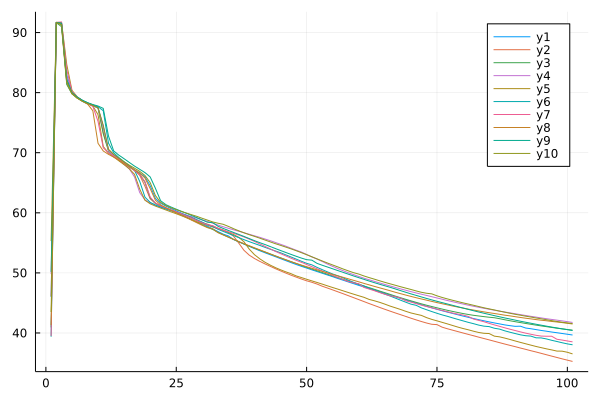

In [26]:
plot(all_aeloss)

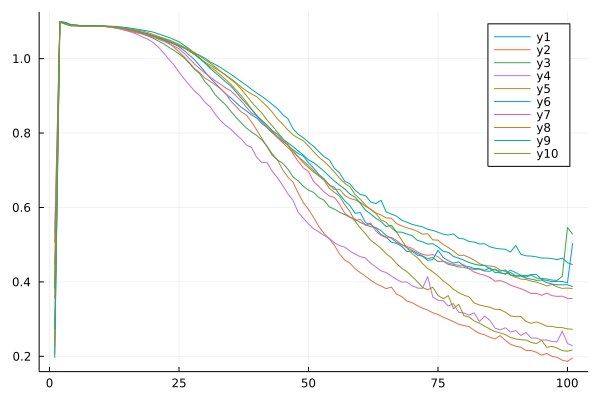

In [27]:
plot(all_mlptrnloss)

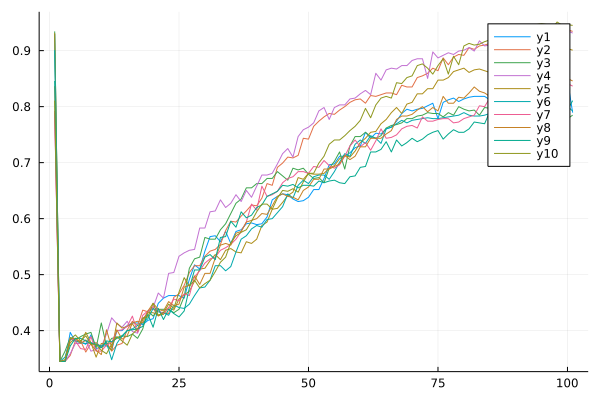

In [28]:
plot(all_mlptrnacc)

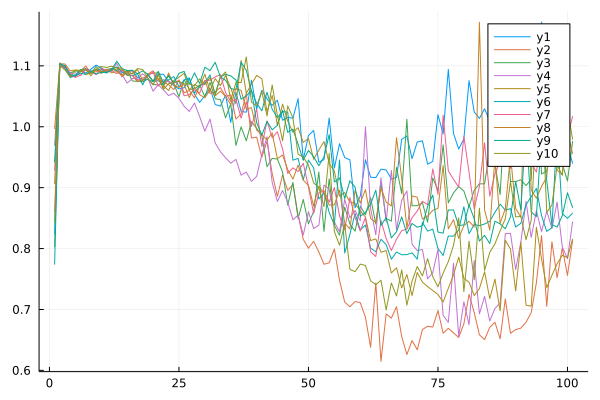

In [41]:
plot(all_mlpvalloss)

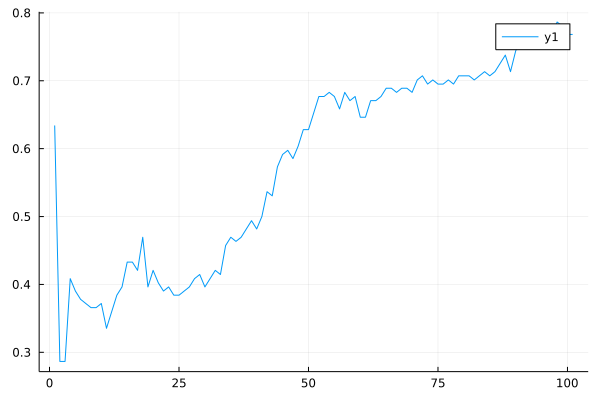

In [56]:
plot(all_mlpvalacc[2])

### Backpropagation

In [57]:
NNX = "NN2" # choose the folder with the best NN
weights1 = CuArray{Float32}(readdlm(NNX*"/weights_new_1.txt"))
weights2 = CuArray{Float32}(readdlm(NNX*"/weights_new_2.txt"))
weights3 = CuArray{Float32}(readdlm(NNX*"/weights_new_4.txt"))
weights4 = CuArray{Float32}(readdlm(NNX*"/weights_new_6.txt"))
weights5 = CuArray{Float32}(readdlm(NNX*"/weights_new_8.txt"))
weights6 = CuArray{Float32}(readdlm(NNX*"/weights_new_10.txt"))
weights7 = CuArray{Float32}(readdlm(NNX*"/weights_new_12.txt"))

3×8 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}:
  2.79201   -0.768343   1.8979    -3.78506  …  -1.32204   0.910007   1.06433
  0.263707  -2.19504   -1.96853    1.44726      3.81268  -2.26308    2.13949
 -6.01471    4.6197    -0.126677   3.49879     -4.51599   2.48325   -5.67788

In [125]:
# Backpropagation
Backprob_mlpae1 =  Chain(
    Dense(weights7',  CuArray(zeros(size(weights7,2))), identity),
    Dense(weights6',  CuArray(zeros(size(weights6,2))), sigm),
    Dense(weights5',  CuArray(zeros(size(weights5,2))), sigm),
    Dense(weights4',  CuArray(zeros(size(weights4,2))), relu),
    Dense(weights3',  CuArray(zeros(size(weights3,2))), sigm),
    Dense(weights2',  CuArray(zeros(size(weights2,2))), sigm),
    x -> weights1 .* x # Feature selection layer
)

Chain(Any[Dense(Float32[-1.1813358 -3.486124 3.8834999; -2.5623586 5.1302767 -5.1323767; … ; 2.9754338 -2.9585738 -0.8183723; 1.0354847 1.6053574 -4.355178], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], identity), Dense(Float32[-2.4248993 1.9173398 … -0.074966304 2.543587; 2.1583705 1.6486744 … -1.5382303 -2.232887; … ; 1.2813509 2.5860353 … -4.3978534 -2.176051; 3.1649647 -2.9017546 … -0.35410136 -2.5946925], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Knet.Ops20.sigm), Dense(Float32[-1.2265927 -1.6245314 … -3.4548755 -3.4189527; -0.17674111 -0.14421132 … -0.18080123 0.05008728; … ; -0.31974003 -2.2870395 … 0.17876497 -0.4313358; -1.1980363 -1.8113704 … -4.025163 -3.5384598], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Knet.Ops20.sigm), Dense(Float32[0.1380293 -0.0012813495 … -0.20219888 0.15704815; 0.33584934 0.0219044 … -0.14138113 0.2849131; … ; 0.20709729 -0.012362933 … 0.57155544 0.198

In [126]:
print_network(Backprob_mlpae1)

NNHelferlein neural network summary:
Chain with 7 layers,                                                 0 params
Details:
 
    Dense layer 3 → 8 with identity,                                 0 params
    Dense layer 8 → 16 with sigm,                                    0 params
    Dense layer 16 → 32 with sigm,                                   0 params
    Dense layer 32 → 64 with relu,                                   0 params
    Dense layer 64 → 256 with sigm,                                  0 params
    Dense layer 256 → 22215 with sigm,                               0 params
 
Total number of layers: 6
Total number of parameters: 0


6

In [127]:
bp1 = Backprob_mlpae1(CuArray{Float32}([1,0,0]));
bp2 = Backprob_mlpae1(CuArray{Float32}([0,1,0]));
bp3 = Backprob_mlpae1(CuArray{Float32}([0,0,1]));

Save results of the backpropagation

In [128]:
writedlm("bp1.txt", bp1)
writedlm("bp2.txt", bp2)
writedlm("bp3.txt", bp3)

### Rebuild the trained NN 

In [58]:
NNX = "NN3" # choose the folder with the best NN
bias2 = CuArray{Float32}(readdlm(NNX*"/weights_new_3.txt"))
bias3 = CuArray{Float32}(readdlm(NNX*"/weights_new_5.txt"))
bias4 = CuArray{Float32}(readdlm(NNX*"/weights_new_7.txt"))
bias5 = CuArray{Float32}(readdlm(NNX*"/weights_new_9.txt"))
bias6 = CuArray{Float32}(readdlm(NNX*"/weights_new_11.txt"))
bias7 = CuArray{Float32}(readdlm(NNX*"/weights_new_13.txt"))

3×1 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}:
  0.35721368
 -0.057054125
 -0.37633744

In [59]:
# Rebuild NN
encodermlp_mlpae_ds1 =  Classifier(
    x -> weights1 .* x, # Feature selection layer
    Dense(weights2, bias2, identity),
    Dense(weights3, bias3, sigm),
    Dense(weights4, bias4, sigm),
    Dense(weights5, bias5, relu),
    Dense(weights6, bias6, sigm),
    Dense(weights7, bias7, sigm)
)

Classifier(Any[var"#5#6"(), Dense(Float32[0.043844614 -0.0088113425 … 0.016806114 -0.036521025; 0.034935582 0.050824136 … 0.02715913 -0.06525167; … ; -0.025113825 -0.032843053 … -0.067727715 0.06552784; 0.06431979 0.010530498 … 0.024164215 -0.0464671], Float32[0.06395502; 0.052043565; … ; -0.03149918; 0.047228705;;], identity), Dense(Float32[-0.09416054 -0.17491677 … 0.042649794 -0.14947519; 0.14051586 -0.03188661 … 0.043529518 0.097908504; … ; -0.1352469 0.022509187 … -0.010630236 -0.10632607; -0.0029241461 0.118480384 … -0.00904384 0.044650115], Float32[0.0070675015; -0.01529995; … ; 0.02064075; -0.018857196;;], Knet.Ops20.sigm), Dense(Float32[0.0031286858 0.020173218 … -0.0072473777 -0.009783765; -0.029472874 -0.09931526 … 0.3004972 0.38163507; … ; 0.43086073 -0.148042 … 0.4416369 -0.12579928; 0.289106 -0.18455802 … 0.7830593 0.12836187], Float32[0.027975753; 0.011681949; … ; 0.07576822; -0.0009850209;;], Knet.Ops20.sigm), Dense(Float32[-0.26907423 -0.006020708 … -0.91165596 0.11379

In [56]:
print_network(encodermlp_mlpae_ds1)

NNHelferlein neural network summary:
Classifier with 7 layers,                                            0 params
Details:
 
    Dense layer 22215 → 256 with identity,                           0 params
    Dense layer 256 → 64 with sigm,                                  0 params
    Dense layer 64 → 32 with sigm,                                   0 params
    Dense layer 32 → 16 with relu,                                   0 params
    Dense layer 16 → 8 with sigm,                                    0 params
    Dense layer 8 → 3 with sigm,                                     0 params
 
Total number of layers: 6
Total number of parameters: 0


6

### Running the test dataset

In [75]:
erg = encodermlp_mlpae_ds1(tst_pN_mb_frame) #loss

1.1339488f0

In [69]:
pred = predict(encodermlp_mlpae_ds1,data=tst_pN_mb_frame, softmax=true) # prediction of the test dataset

(Float32[0.32097876 0.33926722 … 0.40153462 0.31930643; 0.18262507 0.48289776 … 0.16107328 0.49755806; 0.49639624 0.17783494 … 0.4373921 0.1831355], UInt8[0x01 0x01 … 0x01 0x01])

In [60]:
accuracy(encodermlp_mlpae_ds1,data=trn_pN_mb_frame) # accuracy of the training data set for plausibility check

0.35419847328244275

Somthing is not correct! The accuracy of the training data set is bevor the saving and after the rebuilding of the saved NN different. Bevore they are not the same the result of the test data set will not make any sense.